## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5geocomp' #dataset-compression
TRANSFORM = 'fft-statement_2' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
statement_2_fft_1e5geocomp_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5geocomp\\fft\\statement_2'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


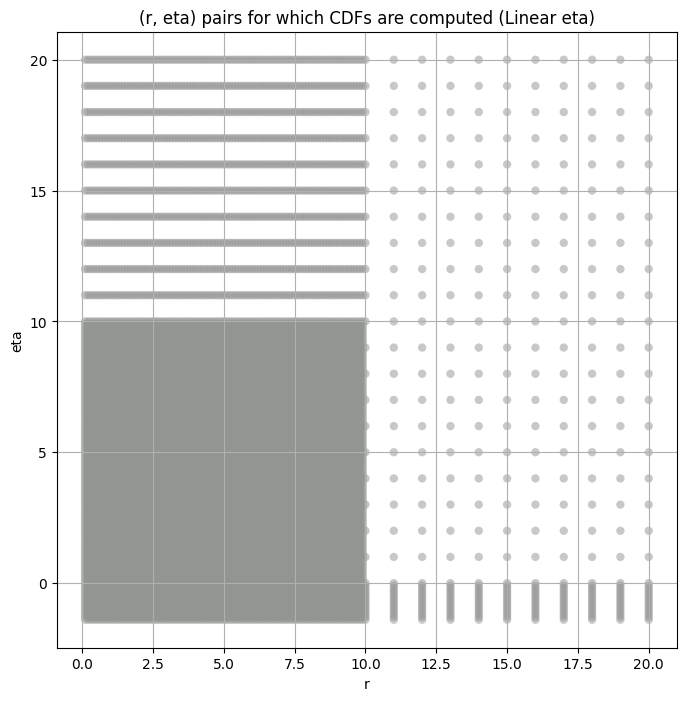

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 17


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 20


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 23


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 26


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 30


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     2.904819e+14  2.597059e+14  3.255609e+14   9.355459    5.162750   
5     4.573241e+14  3.783457e+14  5.454931e+14  48.455196   40.605025   
8     8.089669e+13  6.550185e+13  9.956697e+13  64.661690   38.623471   
11    8.118773e+12  7.500390e+12  9.011517e+12  10.821602    1.944767   
14    2.053679e+14  1.784178e+14  2.367104e+14  27.908864   17.313950   
17    3.885732e+14  3.623203e+14  4.174166e+14   5.466050    3.609352   
20    1.055018e+14  9.697142e+13  1.155315e+14   9.238367    5.192425   
23    1.032575e+13  9.608832e+12  1.124155e+13   7.135820    2.948350   
26    4.818805e+12  4.519782e+12  5.148273e+12   4.349167    2.838751   
30    6.401584e+10  5.894608e+10  6.974965e+10   8.475054    5.367546   

      kurt_upper  total_samples  
band                             
2      13.226103         2880.0  
5      56.285572         8640.0  
8      90.369748        24480.0  
11     31.858465        67680.0  
14     49.301247       100000.0  
17      9.266543       100000.0  
20     23.424463       100000.0  
23     23.809514       100000.0  
26      8.808062       100000.0  
30     19.053446       100000.0

## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                                
2     2.904819e+14   2.904819e+14    2.211539e+14    2.018839e+14   
5     4.573241e+14   4.573241e+14    3.123735e+14    2.411320e+14   
8     8.089669e+13   8.089669e+13    6.393197e+13    5.561511e+13   
11    8.118773e+12   8.118773e+12    7.693572e+12    7.548864e+12   
14    2.053679e+14   2.053679e+14    1.902598e+14    1.822883e+14   
17    3.885732e+14   3.885732e+14    3.772224e+14    3.704985e+14   
20    1.055018e+14   1.055018e+14    1.013224e+14    9.908266e+13   
23    1.032575e+13   1.032575e+13    9.938755e+12    9.757013e+12   
26    4.818805e+12   4.818805e+12    4.697396e+12    4.623842e+12   
30    6.401584e+10   6.401584e+10    6.172509e+10    6.042138e+10   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2       1.876066e+14     1.761259e+14     1.585357e+14     1.444229e+14   
5       2.009603e+14     1.746854e+14     1.430380e+14     1.251067e+14   
8       5.056788e+13     4.710607e+13     4.261697e+13     3.973374e+13   
11      7.446752e+12     7.361758e+12     7.225634e+12     7.112355e+12   
14      1.761495e+14     1.708222e+14     1.618496e+14     1.543574e+14   
17      3.649848e+14     3.601953e+14     3.519587e+14     3.448927e+14   
20      9.727671e+13     9.572235e+13     9.307631e+13     9.082156e+13   
23      9.614634e+12     9.493310e+12     9.288637e+12     9.114721e+12   
26      4.562889e+12     4.509285e+12     4.415883e+12     4.334736e+12   
30      5.935432e+10     5.842550e+10     5.682403e+10     5.544429e+10   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2        1.325221e+14     1.217878e+14     1.124131e+14     9.041855e+13  
5        1.138436e+14     1.060863e+14     1.001682e+14     8.739761e+13  
8        3.772484e+13     3.621975e+13     3.507316e+13     3.269610e+13  
11       7.013755e+12     6.927033e+12     6.848530e+12     6.645458e+12  
14       1.478917e+14     1.421563e+14     1.369469e+14     1.237775e+14  
17       3.386248e+14     3.329140e+14     3.276576e+14     3.138177e+14  
20       8.883365e+13     8.703937e+13     8.539907e+13     8.112952e+13  
23       8.961407e+12     8.823229e+12     8.696333e+12     8.365061e+12  
26       4.261958e+12     4.195489e+12     4.134012e+12     3.971839e+12  
30       5.421655e+10     5.310241e+10     5.207712e+10     4.939767e+10

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.00705488879895716 290481892974556.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.008949141473035938 221153935360470.53


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.01450143146337024 201883919494433.66


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.01899080051803674 187606557270896.66


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.023174378652960903 176125903271873.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.033322258815953854 158535695459350.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.04398925215915883 144422942655709.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.05381633620548043 132522131967319.84


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.0634241418183511 121787827215664.81


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.07246308655488995 112413073127322.78


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.09643582577463328 90418552811723.83
Number of samples: 5760, Without approximation : 2880.0


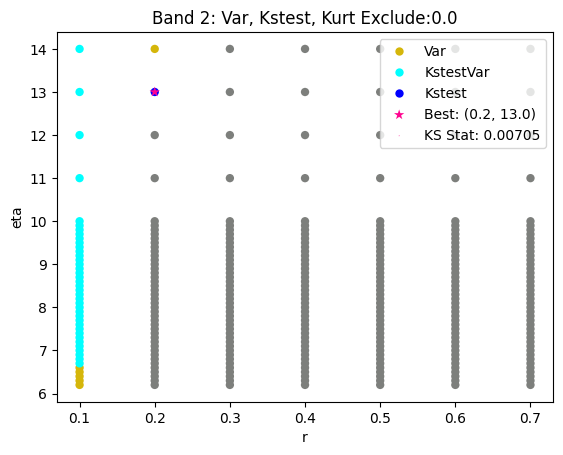

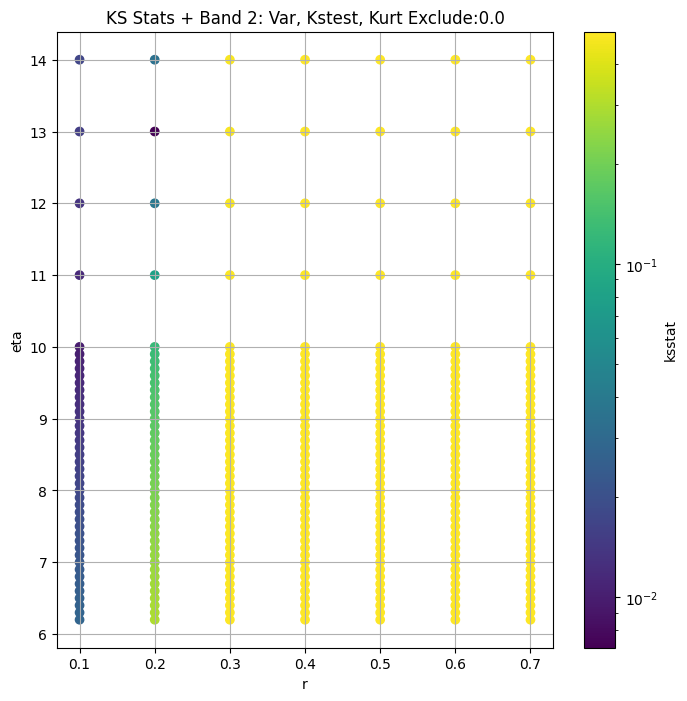

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.017250487398262786 457324141300332.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.017250487398262786 312373467132423.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.017250487398262786 241131982810367.22


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.015134899882872088 200960252044485.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.010578768842335273 174685395176925.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.010688665737266624 143037960246473.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.012635157807499575 125106687031808.39


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.01696792331519914 113843617019540.16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.019237170466622544 106086337801742.03


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.022385766282796614 100168205555305.39


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.03367782536487163 87397613815513.97
Number of samples: 17280, Without approximation : 8640.0


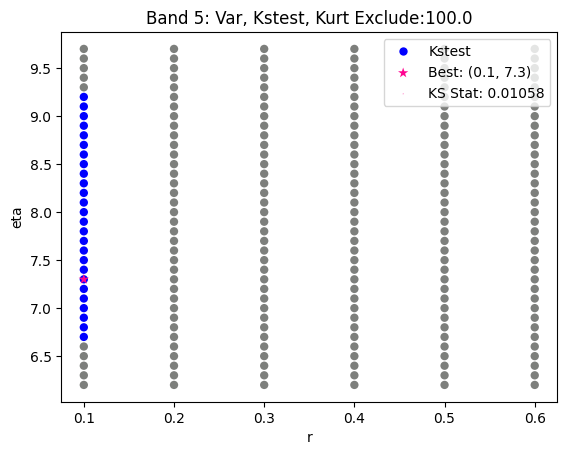

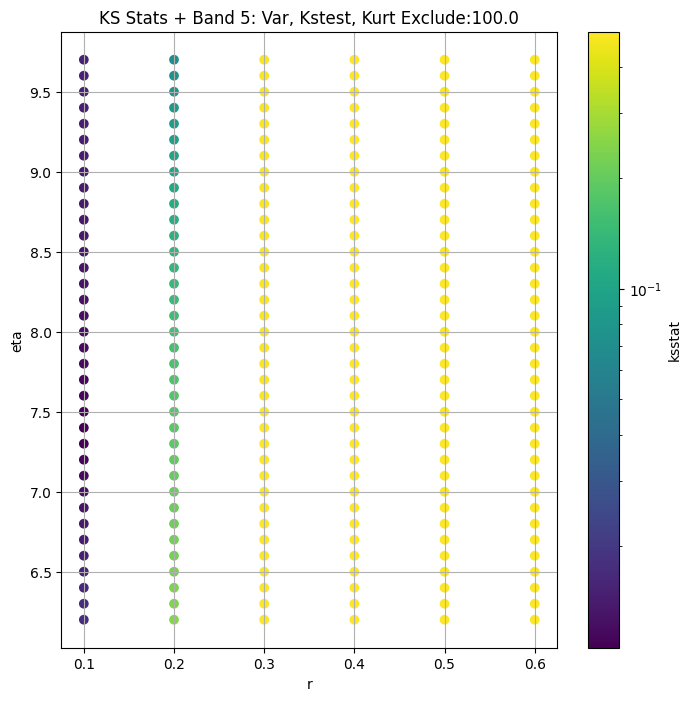

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.00712520828415826 80896687420698.11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.00712520828415826 63931966874101.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.00712520828415826 55615108201879.71


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.00712520828415826 50567876410301.98


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.00712520828415826 47106069619879.45


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.00712520828415826 42616974328250.26


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.005626318526224644 39733737444388.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.006180989597658216 37724836140341.66


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.007104728025124296 36219754522347.88


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.008027313102834444 35073162797752.797


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.011721253193878067 32696097135775.098
Number of samples: 48960, Without approximation : 24480.0


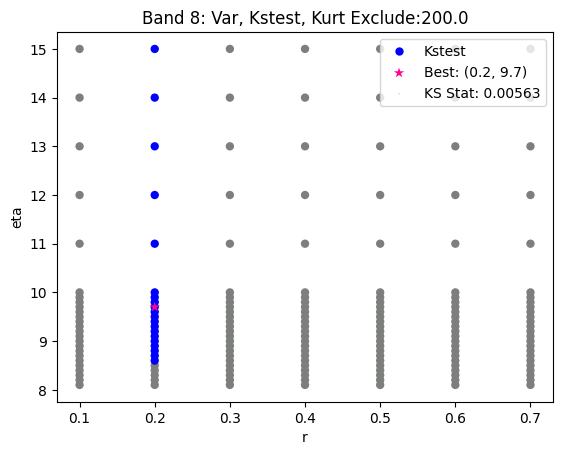

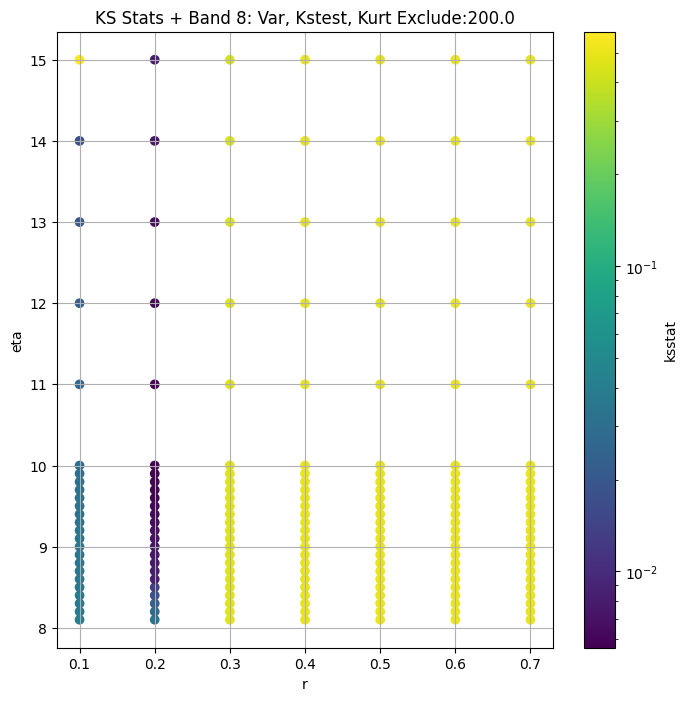

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.00692448981982452 8118773388848.815


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.003952693704790011 7693571723521.428


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.0029562100639126676 7548863832170.454


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.0023686201474542035 7446751803967.127


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.0018373660232671174 7361758225193.573


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.0021617666506149923 7225633581290.623


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.003745894397834154 7112354726967.356


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.005343290174669696 7013755432305.576


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.006766741017098649 6927032603113.877


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.008070462816987006 6848529645621.021


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.011511718995762116 6645458298231.194
Number of samples: 100000, Without approximation : 67680.0


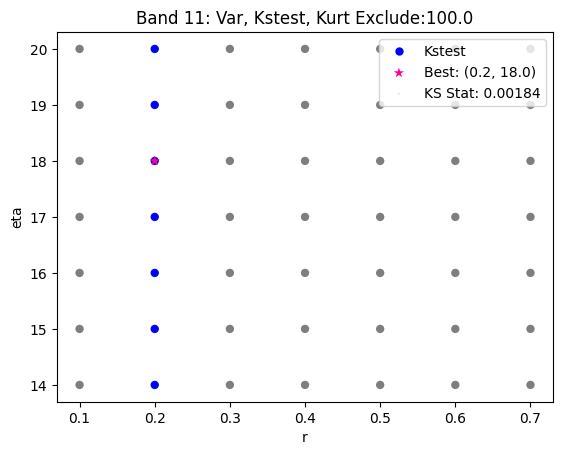

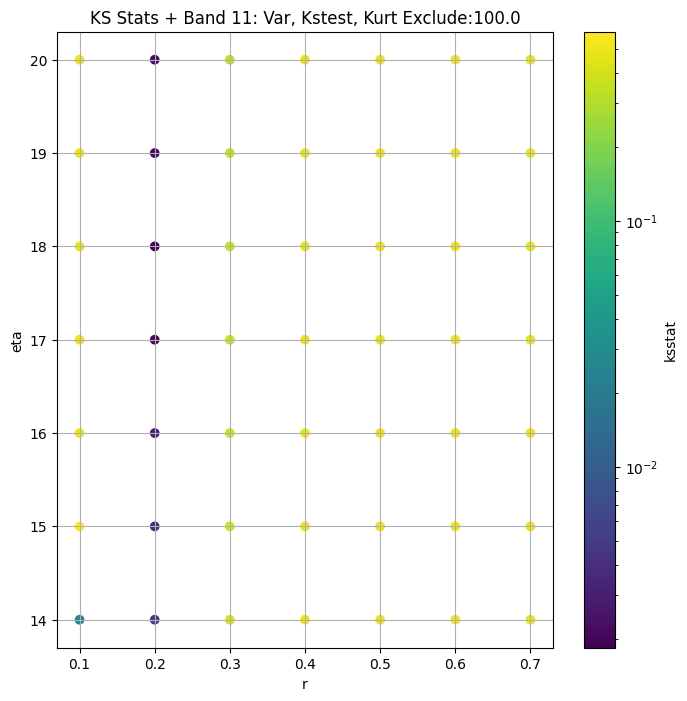

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.02423852296901291 205367930545635.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.026051791435137805 190259785923373.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.023499631053280234 182288327551764.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.021456654813441056 176149537687886.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.02106360633809117 170822221562465.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.022880324391791995 161849557229813.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.023414311153048373 154357364758525.34


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.02311653363968834 147891721103724.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.02431681056723972 142156260206863.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.0252031119327627 136946861457273.17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.026507115204669578 123777497666097.73
Number of samples: 100000, Without approximation : 100000.0


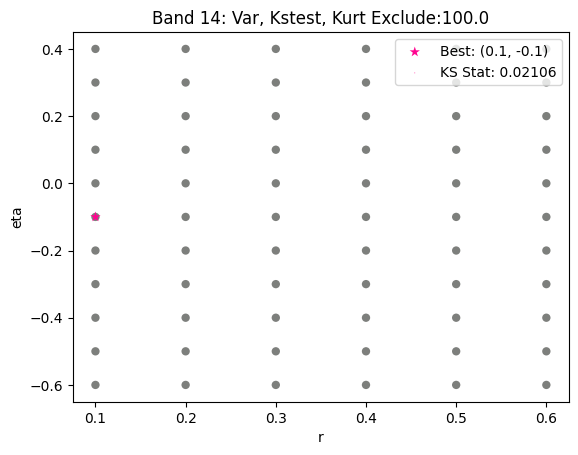

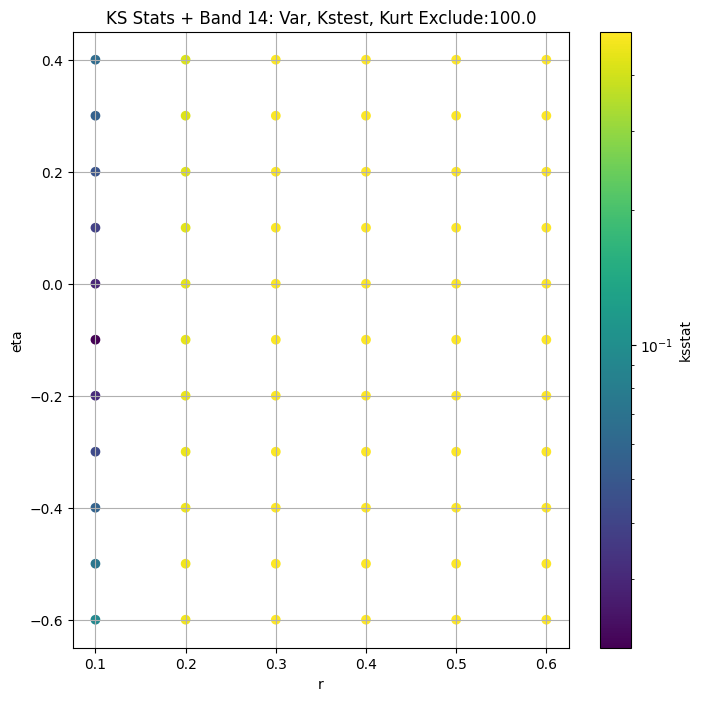

####
Band  17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 0 0.008616537618701514 388573155934066.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 25 0.009191351584170948 377222357197183.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 50 0.009570560823019214 370498465431801.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 75 0.010022077964730675 364984845027285.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 100 0.010147828923714242 360195251434356.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 150 0.010820938906735453 351958709986303.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 200 0.011387170790331788 344892661413970.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 250 0.011909308938215818 338624792250966.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 300 0.012413362303778736 332914019797455.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 350 0.012921103804659953 327657599482375.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 500 0.014187821525232042 313817664844928.3
Number of samples: 100000, Without approximation : 100000.0


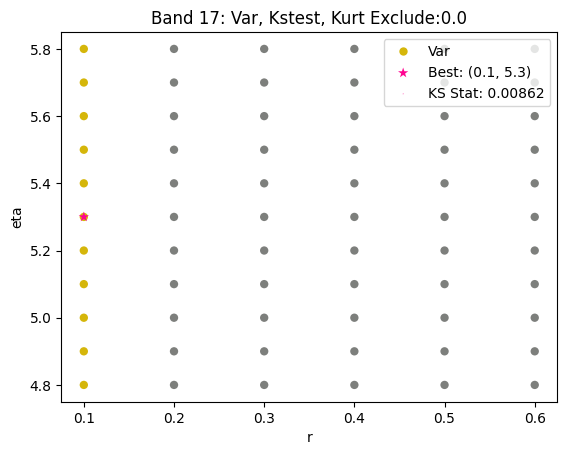

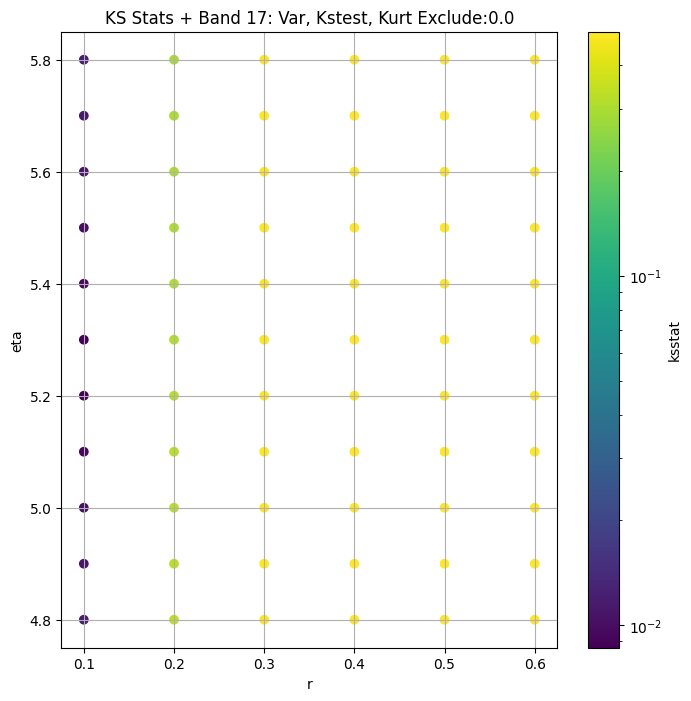

####
Band  20


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 0 0.00332298540756093 105501761645936.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 25 0.0025660318574745045 101322422699165.42


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 50 0.002267577754206239 99082664965249.69


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 75 0.002832509632182876 97276705607847.27


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 100 0.0033406541840555505 95722346757315.64


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 150 0.004268740352076576 93076305958600.36


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 200 0.005137867702839229 90821563455303.23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 250 0.005967811110173048 88833651749036.45


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 300 0.006760694278596362 87039373689431.31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 350 0.007509291200830919 85399074657733.78


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 500 0.009593134126360526 81129516440490.67
Number of samples: 100000, Without approximation : 100000.0


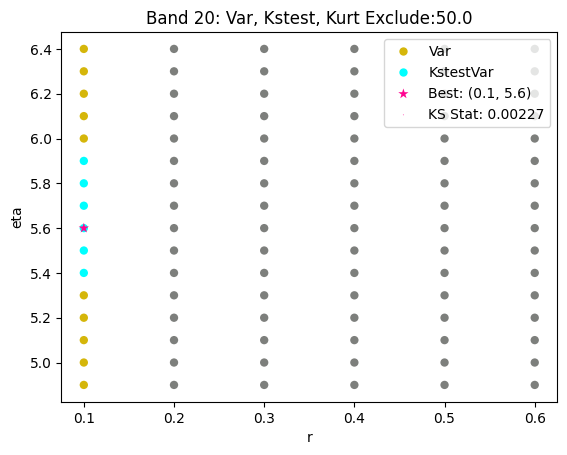

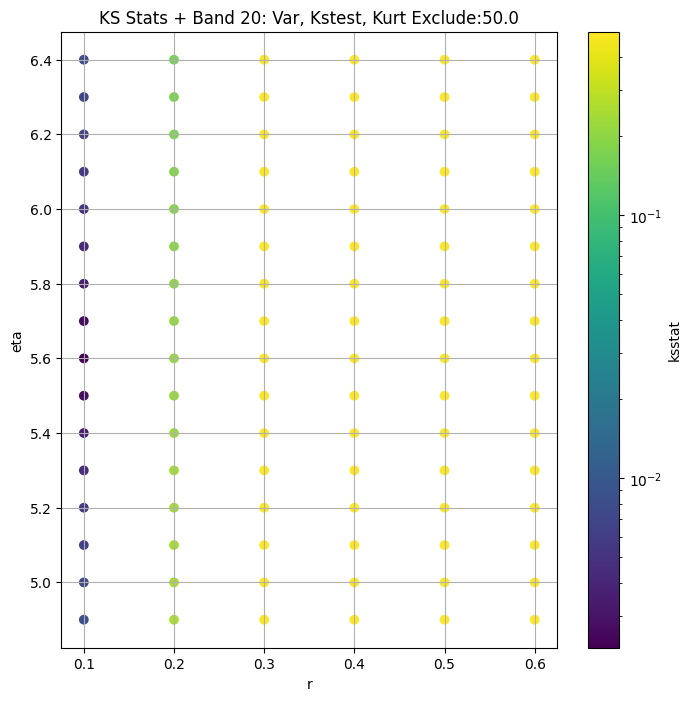

####
Band  23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 0 0.0027028783421355618 10325747762119.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 25 0.0022648978485688698 9938754859287.533


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 50 0.0010120006227607448 9757012819852.635


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 75 0.0014680929053964963 9614634450559.65


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 100 0.001784702028004164 9493309759000.514


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 150 0.002559888176040595 9288637322069.98


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 200 0.0034061124172419 9114721300741.246


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 250 0.004277529468615968 8961406505259.607


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 300 0.0051004514079800375 8823229353578.145


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 350 0.0058806568502466 8696333395193.577


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 500 0.00805124486767625 8365061408389.344
Number of samples: 100000, Without approximation : 100000.0


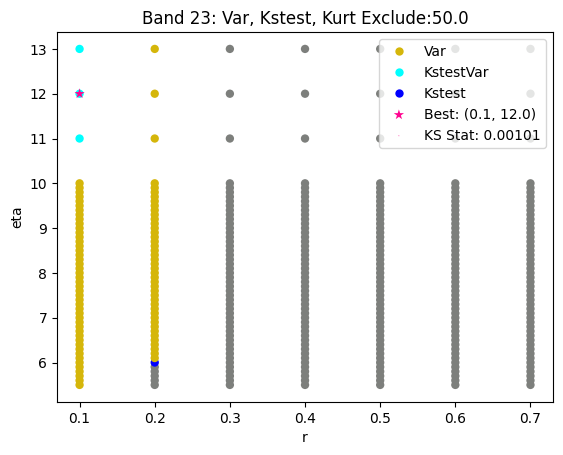

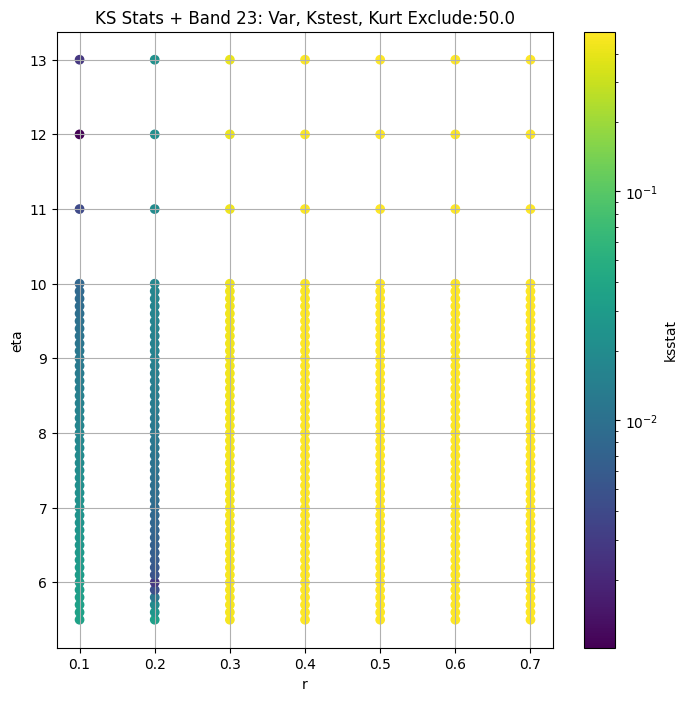

####
Band  26


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 0 0.0003996630873854823 4818804752607.261


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 25 0.0012165808623742363 4697396013228.634


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 50 0.0018871924247743088 4623841971400.235


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 75 0.0025168036989384815 4562888789666.627


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 100 0.003205515072182745 4509284821483.746


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 150 0.00366444481035319 4415882969087.908


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 200 0.004529070120526862 4334735936827.758


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 250 0.005360063116074197 4261957989580.698


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 300 0.0061466718159511255 4195488828225.5723


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 350 0.0069028464748438 4134012069461.4146


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 500 0.0090172826039688 3971839198207.493
Number of samples: 100000, Without approximation : 100000.0


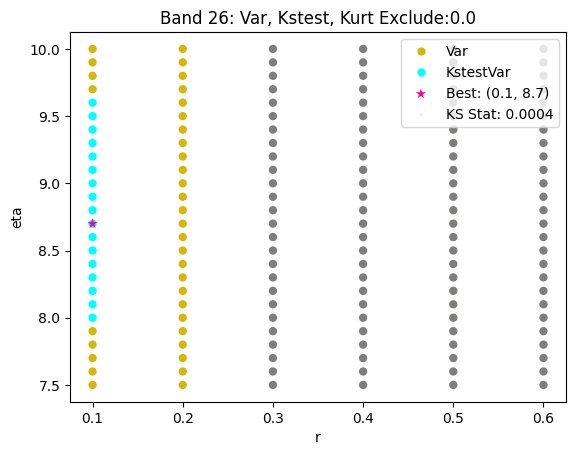

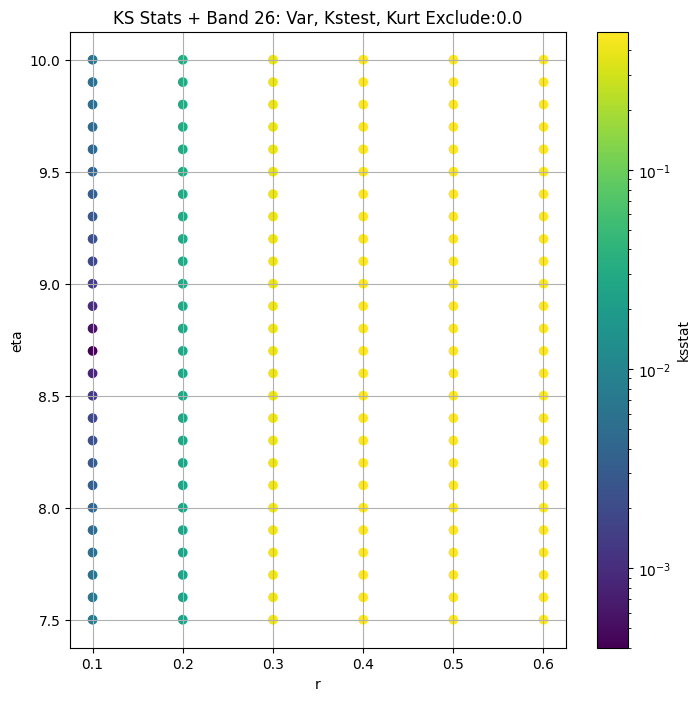

####
Band  30


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 0 0.0029847473605027625 64015836146.25255


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 25 0.0031865022972442647 61725086227.34663


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 50 0.0038960694845710728 60421381139.42532


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 75 0.0044090850503553936 59354323423.27613


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 100 0.004876329926524571 58425498539.53066


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 150 0.0059339969683235225 56824032209.90899


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 200 0.006661086140963272 55444290017.437904


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 250 0.0075233137883099 54216545645.95895


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 300 0.008339587053420083 53102413253.73835


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 350 0.009114012867975196 52077120399.38033


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 500 0.011142092948574704 49397665869.12707
Number of samples: 100000, Without approximation : 100000.0


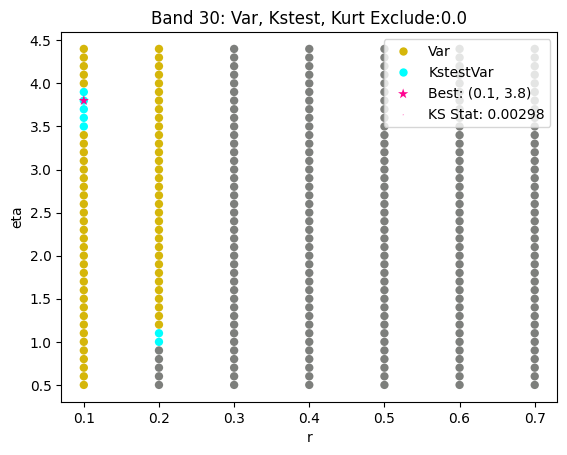

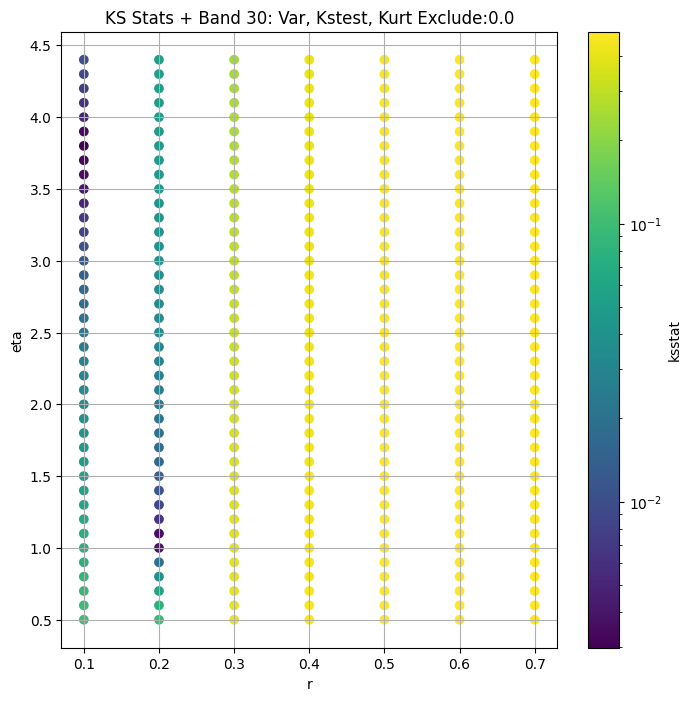

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     2.904819e+14  2.597059e+14  3.255609e+14   9.355459    5.162750   
5     4.573241e+14  3.783457e+14  5.454931e+14  48.455196   40.605025   
8     8.089669e+13  6.550185e+13  9.956697e+13  64.661690   38.623471   
11    8.118773e+12  7.500390e+12  9.011517e+12  10.821602    1.944767   
14    2.053679e+14  1.784178e+14  2.367104e+14  27.908864   17.313950   
17    3.885732e+14  3.623203e+14  4.174166e+14   5.466050    3.609352   
20    1.055018e+14  9.697142e+13  1.155315e+14   9.238367    5.192425   
23    1.032575e+13  9.608832e+12  1.124155e+13   7.135820    2.948350   
26    4.818805e+12  4.519782e+12  5.148273e+12   4.349167    2.838751   
30    6.401584e+10  5.894608e+10  6.974965e+10   8.475054    5.367546   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      13.226103         2880.0             0.007055        0.2         13.0   
5      56.285572         8640.0             0.010579        0.1          7.3   
8      90.369748        24480.0             0.005626        0.2          9.7   
11     31.858465        67680.0             0.001837        0.2         18.0   
14     49.301247       100000.0             0.021064        0.1         -0.1   
17      9.266543       100000.0             0.008617        0.1          5.3   
20     23.424463       100000.0             0.002268        0.1          5.6   
23     23.809514       100000.0             0.001012        0.1         12.0   
26      8.808062       100000.0             0.000400        0.1          8.7   
30     19.053446       100000.0             0.002985        0.1          3.8   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      1.000000e+05                     0.0        2.904819e+14   
5      3.827673e-06                   100.0        1.746854e+14   
8      6.062689e+04                   200.0        3.973374e+13   
11     7.552409e+02                   100.0        7.361758e+12   
14     4.114625e+01                   100.0        1.708222e+14   
17     9.761257e-05                     0.0        3.885732e+14   
20     1.658345e-05                    50.0        9.908266e+13   
23     3.503448e-09                    50.0        9.757013e+12   
26     2.576462e-08                     0.0        4.818805e+12   
30     1.640739e-07                     0.0        6.401584e+10   

      kstest_stat_cutoff_0.05  
band                           
2                    0.025248  
5                    0.014591  
8                    0.008673  
11                   0.005218  
14                   0.004293  
17                   0.004293  
20                   0.004293  
23                   0.004293  
26                   0.004293  
30                   0.004293

In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 100 = 100, ksstat: 0.027688483382728557, var: 176125903271873.9


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 75 = 75, ksstat: 0.020655873065585112, var: 187606557270896.66


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 50 = 50, ksstat: 0.01449478238563462, var: 201883919494433.66


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 25 = 25, ksstat: 0.008949141473035938, var: 221153935360470.53


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 0 = 0, ksstat: 0.00705488879895716, var: 290481892974556.25
Number of samples: 5760, Without approximation : 2880.0


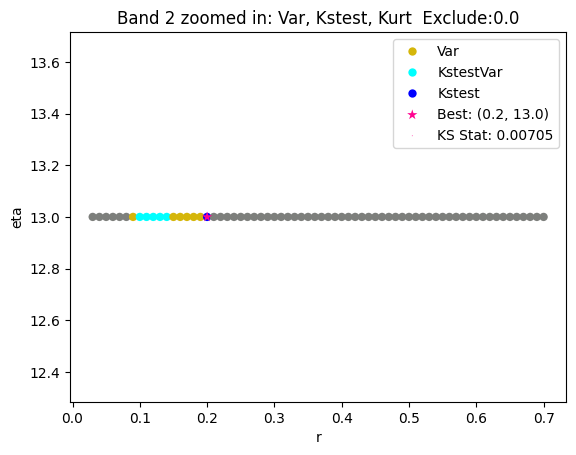

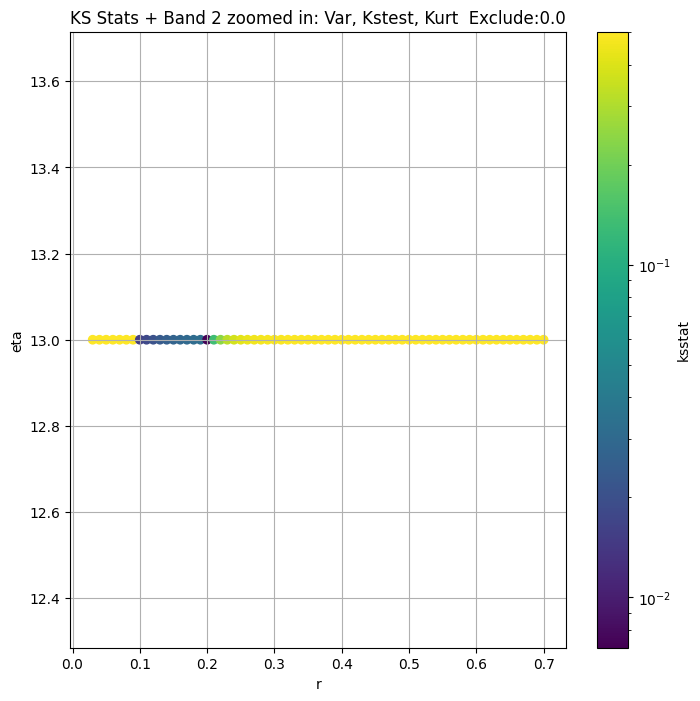

Band 5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 100 = 200, ksstat: 0.012648116470093007, var: 125106687031808.39


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 75 = 175, ksstat: 0.011506759356452734, var: 132936945713636.9


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 50 = 150, ksstat: 0.010606760773148866, var: 143037960246473.8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 25 = 125, ksstat: 0.00965098097025563, var: 156521089888725.22


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 0 = 100, ksstat: 0.010578768842335273, var: 174685395176925.1


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + -25 = 75, ksstat: 0.014895400979809903, var: 200960252044485.06


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + -50 = 50, ksstat: 0.019701723937201307, var: 241131982810367.22


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + -75 = 25, ksstat: 0.03516234558272702, var: 312373467132423.9


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + -100 = 0, ksstat: 0.03901521931904944, var: 457324141300332.56
Number of samples: 17280, Without approximation : 8640.0


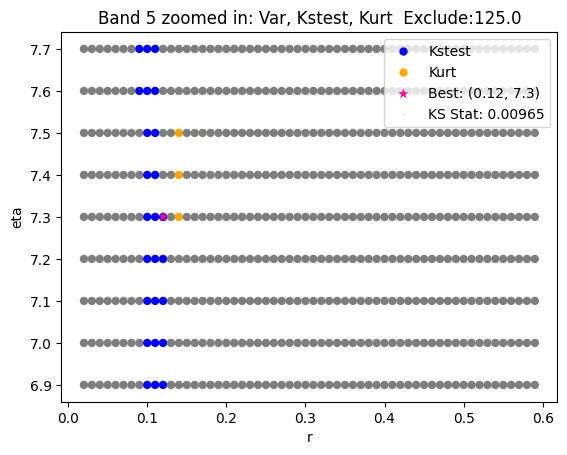

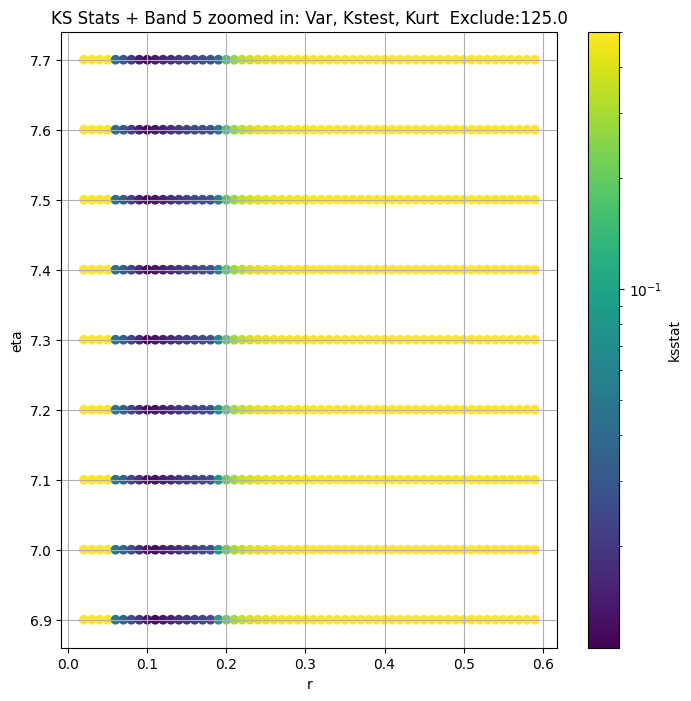

Band 8


  0%|          | 0/551 [00:00<?, ?it/s]

Finding Minimum after computing 551 CDFs
band 8, 200.0 + 100 = 300, ksstat: 0.01358399123848597, var: 36219754522347.88


  0%|          | 0/551 [00:00<?, ?it/s]

Finding Minimum after computing 551 CDFs
band 8, 200.0 + 75 = 275, ksstat: 0.011705497389022768, var: 36925306965672.47


  0%|          | 0/551 [00:00<?, ?it/s]

Finding Minimum after computing 551 CDFs
band 8, 200.0 + 50 = 250, ksstat: 0.009630507110391595, var: 37724836140341.66


  0%|          | 0/551 [00:00<?, ?it/s]

Finding Minimum after computing 551 CDFs
band 8, 200.0 + 25 = 225, ksstat: 0.007293883467838325, var: 38651468220238.36


  0%|          | 0/551 [00:00<?, ?it/s]

Finding Minimum after computing 551 CDFs
band 8, 200.0 + 0 = 200, ksstat: 0.005626318526224644, var: 39733737444388.2


  0%|          | 0/551 [00:00<?, ?it/s]

Finding Minimum after computing 551 CDFs
band 8, 200.0 + -25 = 175, ksstat: 0.0053391776433142635, var: 41022034479863.46


  0%|          | 0/551 [00:00<?, ?it/s]

Finding Minimum after computing 551 CDFs
band 8, 200.0 + -50 = 150, ksstat: 0.006673524793350483, var: 42616974328250.26


  0%|          | 0/551 [00:00<?, ?it/s]

Finding Minimum after computing 551 CDFs
band 8, 200.0 + -75 = 125, ksstat: 0.008449806605281496, var: 44547674572702.35


  0%|          | 0/551 [00:00<?, ?it/s]

Finding Minimum after computing 551 CDFs
band 8, 200.0 + -100 = 100, ksstat: 0.010594748119329589, var: 47106069619879.45
Number of samples: 48960, Without approximation : 24480.0


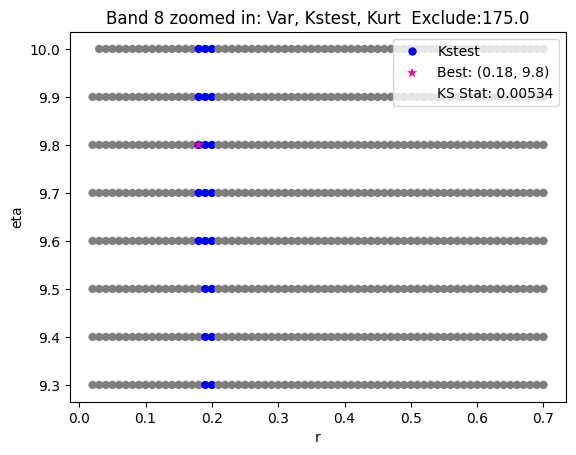

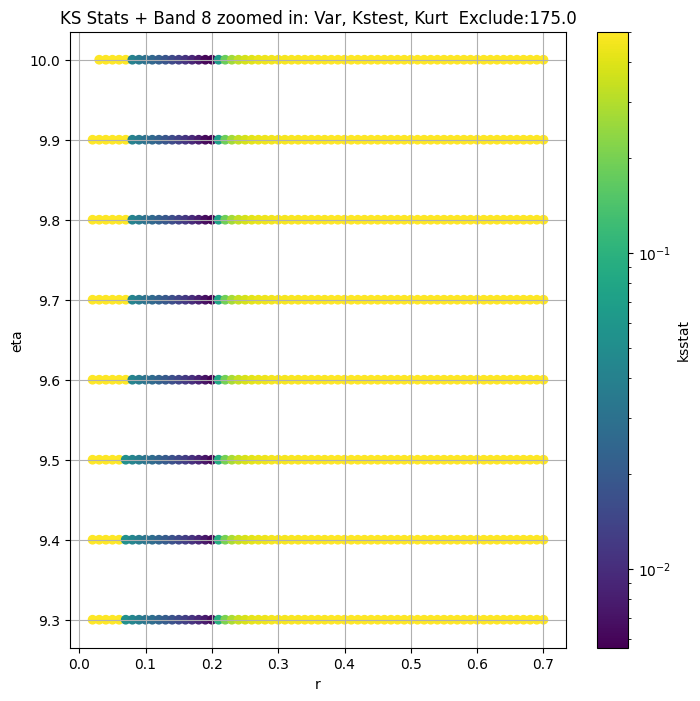

Band 11


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 100.0 + 100 = 200, ksstat: 0.0026894712549203857, var: 7112354726967.356


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 100.0 + 75 = 175, ksstat: 0.002416491710053214, var: 7166720373821.95


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 100.0 + 50 = 150, ksstat: 0.002160711520332501, var: 7225633581290.623


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 100.0 + 25 = 125, ksstat: 0.0019034907953907679, var: 7289943456331.429


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 100.0 + 0 = 100, ksstat: 0.0018373660232671174, var: 7361758225193.573


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 100.0 + -25 = 75, ksstat: 0.0023538734797884375, var: 7446751803967.127


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 100.0 + -50 = 50, ksstat: 0.0029205236717722016, var: 7548863832170.454


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 100.0 + -75 = 25, ksstat: 0.003876992537988011, var: 7693571723521.428


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 100.0 + -100 = 0, ksstat: 0.007353865003838167, var: 8118773388848.815
Number of samples: 100000, Without approximation : 67680.0


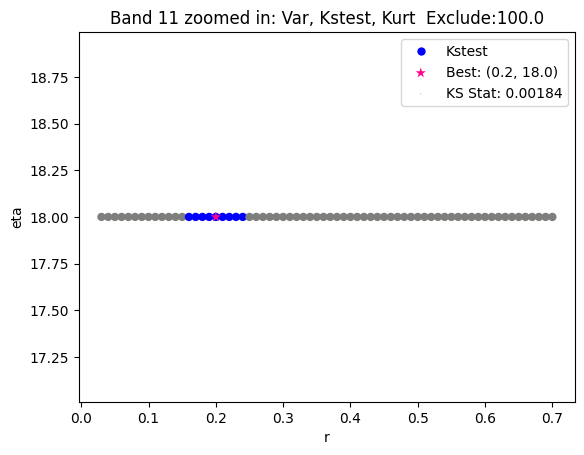

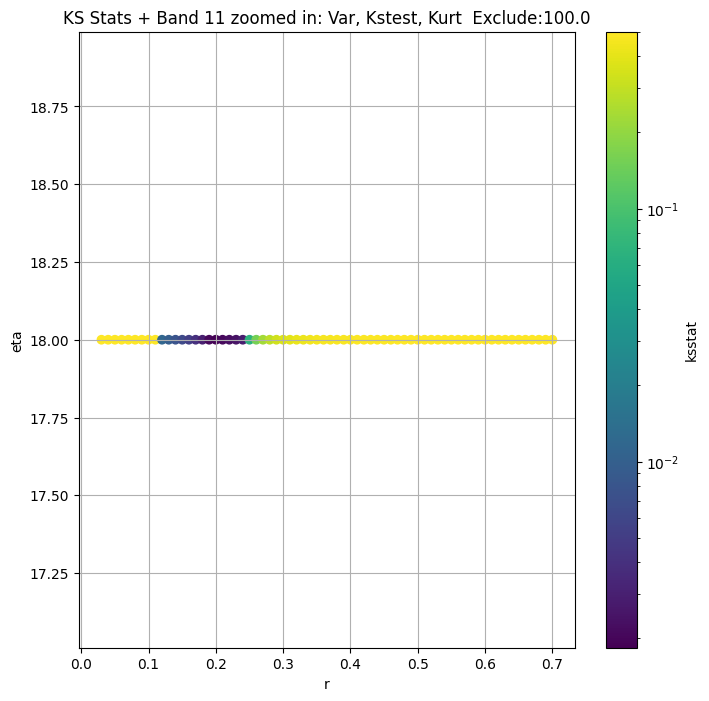

Band 14


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 100.0 + 100 = 200, ksstat: 0.02211269322591236, var: 154357364758525.34


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 100.0 + 75 = 175, ksstat: 0.021675858543644483, var: 157957107044450.8


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 100.0 + 50 = 150, ksstat: 0.021487533292596242, var: 161849557229813.44


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 100.0 + 25 = 125, ksstat: 0.02117476230640903, var: 166096177704970.78


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 100.0 + 0 = 100, ksstat: 0.02081005015926593, var: 170822221562465.3


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 100.0 + -25 = 75, ksstat: 0.020913602853296243, var: 176149537687886.5


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 100.0 + -50 = 50, ksstat: 0.02140048839213493, var: 182288327551764.44


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 100.0 + -75 = 25, ksstat: 0.021797360661481968, var: 190259785923373.3


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 14, 100.0 + -100 = 0, ksstat: 0.02072392705261361, var: 205367930545635.0
Number of samples: 100000, Without approximation : 100000.0


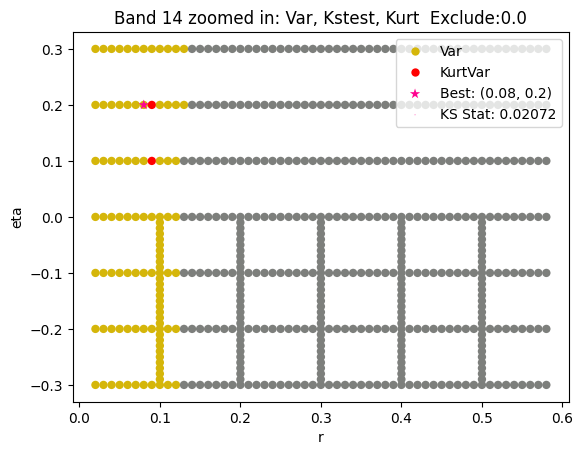

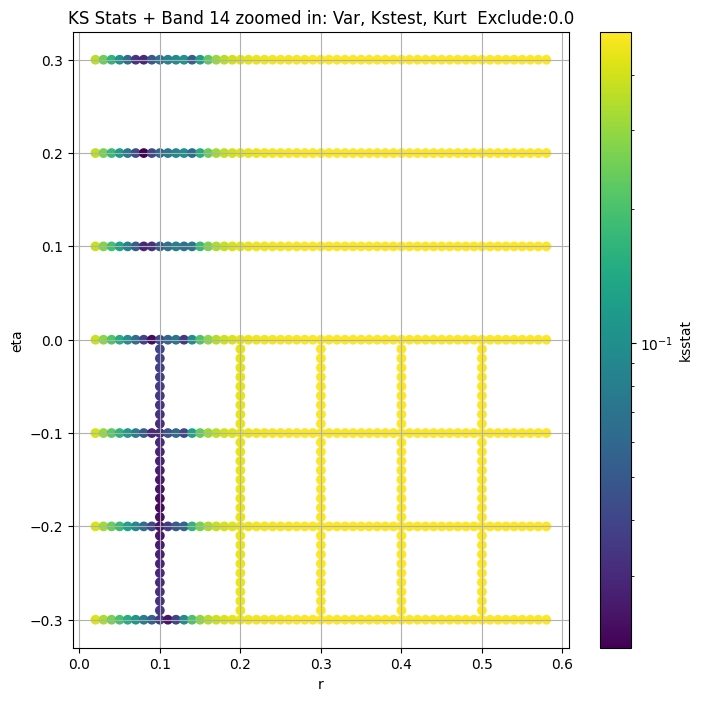

Band 17


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 100 = 100, ksstat: 0.00997776610881529, var: 360195251434356.6


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 75 = 75, ksstat: 0.00992938852218983, var: 364984845027285.44


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 50 = 50, ksstat: 0.009387056923771064, var: 370498465431801.56


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 25 = 25, ksstat: 0.008887408279104392, var: 377222357197183.44


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 0 = 0, ksstat: 0.008616537618701514, var: 388573155934066.6
Number of samples: 100000, Without approximation : 100000.0


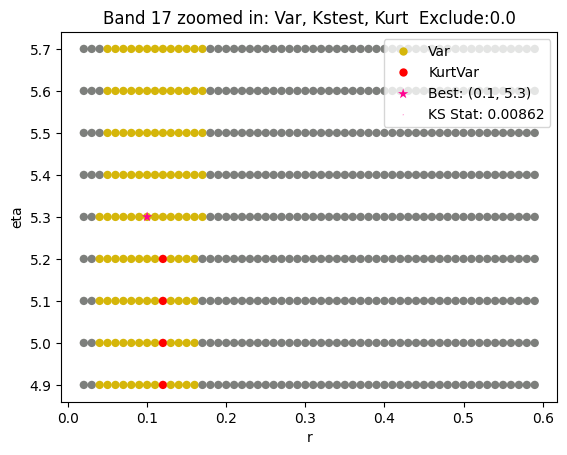

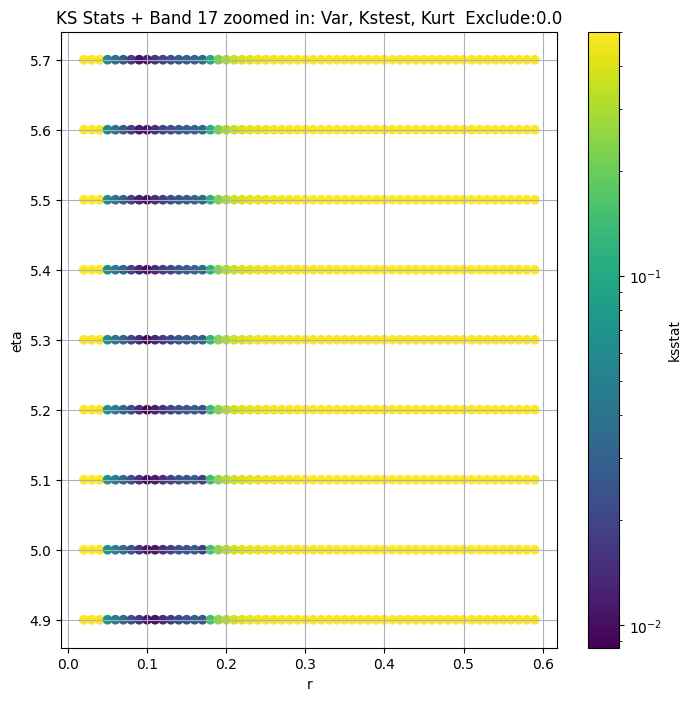

Band 20


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + 100 = 150, ksstat: 0.004196994506479312, var: 93076305958600.36


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + 75 = 125, ksstat: 0.0037734700165190684, var: 94334740024365.81


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + 50 = 100, ksstat: 0.003296094159934801, var: 95722346757315.64


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + 25 = 75, ksstat: 0.0028078494349746234, var: 97276705607847.27


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + 0 = 50, ksstat: 0.002267577754206239, var: 99082664965249.69


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + -25 = 25, ksstat: 0.0025660318574745045, var: 101322422699165.42


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + -50 = 0, ksstat: 0.003466432044706591, var: 105501761645936.2
Number of samples: 100000, Without approximation : 100000.0


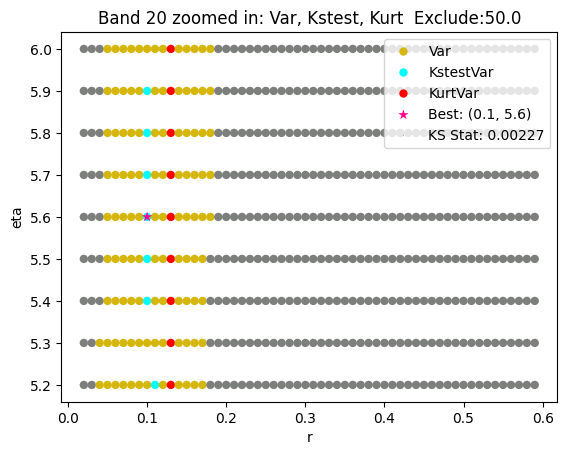

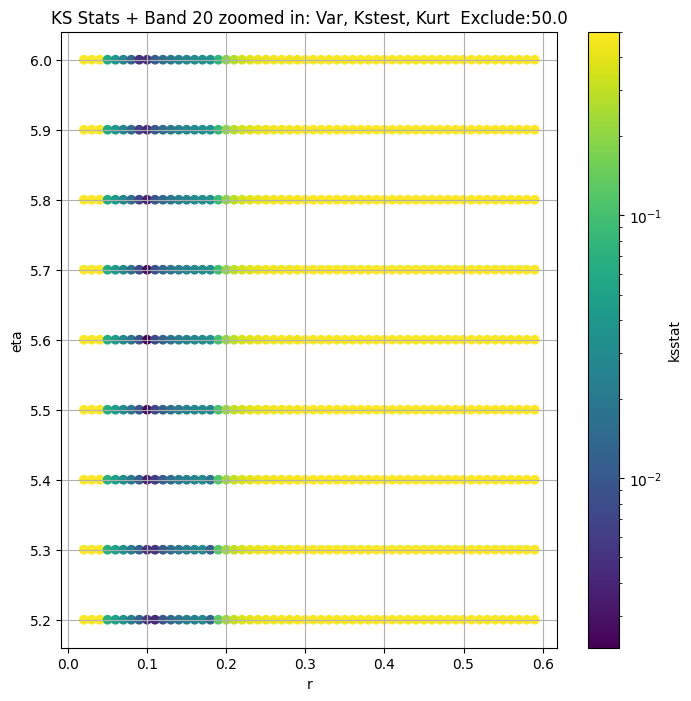

Band 23


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 100 = 150, ksstat: 0.0026980127289504136, var: 9288637322069.98


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 75 = 125, ksstat: 0.0022437469366643897, var: 9385981085780.19


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 50 = 100, ksstat: 0.001857545942887659, var: 9493309759000.514


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 25 = 75, ksstat: 0.002103051442876036, var: 9614634450559.65


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 0 = 50, ksstat: 0.0010120006227607448, var: 9757012819852.635


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + -25 = 25, ksstat: 0.0022648978485688698, var: 9938754859287.533


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + -50 = 0, ksstat: 0.003394351963088238, var: 10325747762119.2
Number of samples: 100000, Without approximation : 100000.0


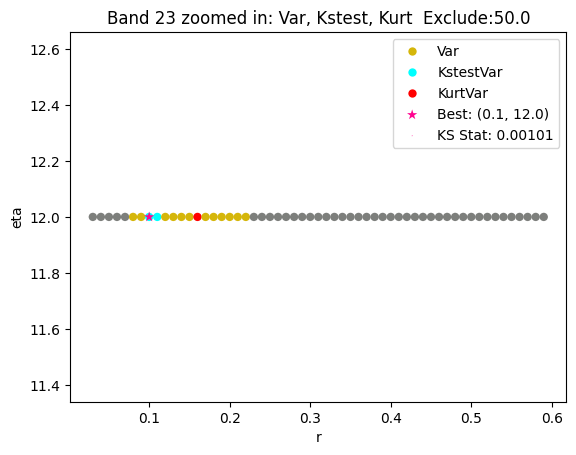

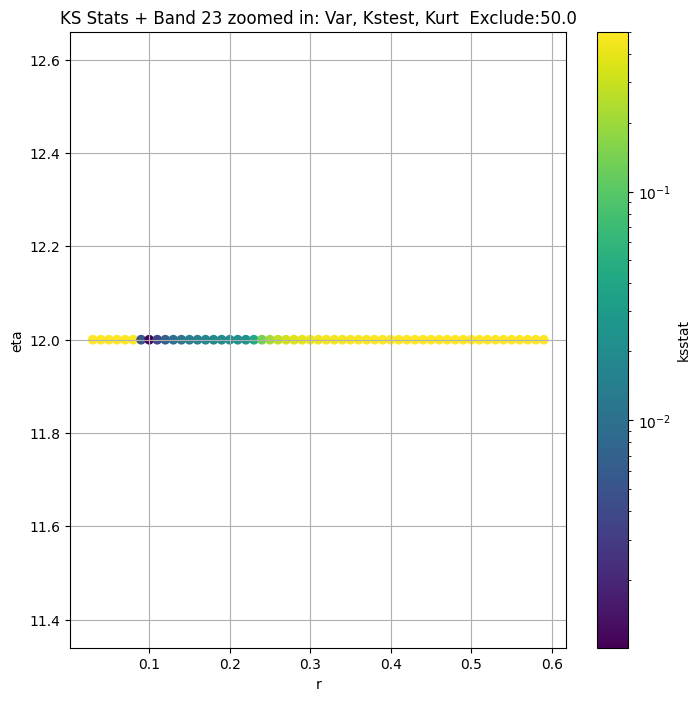

Band 26


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 100 = 100, ksstat: 0.0029232589460571265, var: 4509284821483.746


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 75 = 75, ksstat: 0.0023995994970216483, var: 4562888789666.627


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 50 = 50, ksstat: 0.0018527515686797696, var: 4623841971400.235


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 25 = 25, ksstat: 0.001180408613815305, var: 4697396013228.634


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 0 = 0, ksstat: 0.0003996630873854823, var: 4818804752607.261
Number of samples: 100000, Without approximation : 100000.0


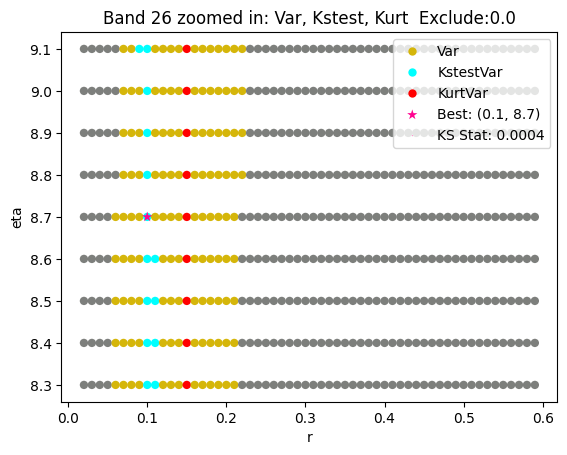

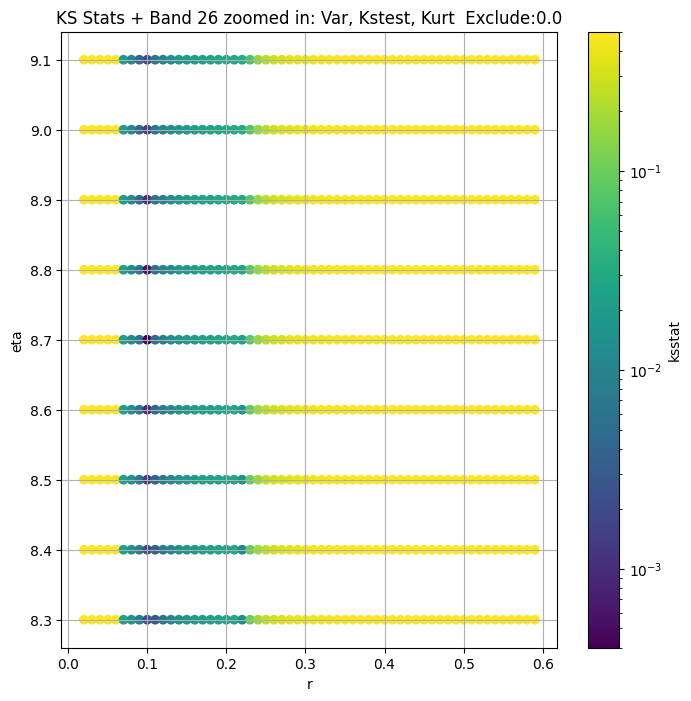

Band 30


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 0.0 + 100 = 100, ksstat: 0.005642192270808095, var: 58425498539.53066


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 0.0 + 75 = 75, ksstat: 0.005078460665955735, var: 59354323423.27613


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 0.0 + 50 = 50, ksstat: 0.004674909346055148, var: 60421381139.42532


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 0.0 + 25 = 25, ksstat: 0.0038527157910627496, var: 61725086227.34663


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 0.0 + 0 = 0, ksstat: 0.0029847473605027625, var: 64015836146.25255
Number of samples: 100000, Without approximation : 100000.0


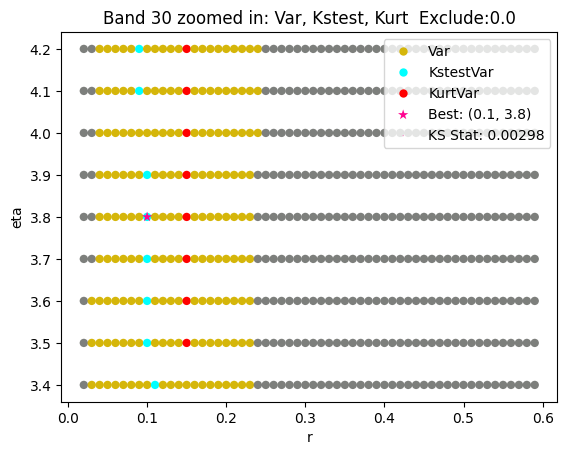

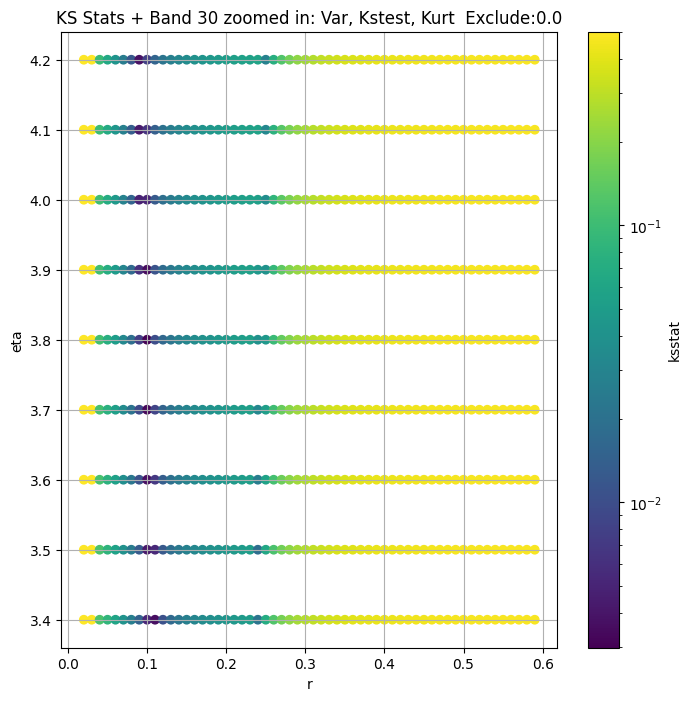

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     2.904819e+14  2.597059e+14  3.255609e+14   9.355459    5.162750   
5     4.573241e+14  3.783457e+14  5.454931e+14  48.455196   40.605025   
8     8.089669e+13  6.550185e+13  9.956697e+13  64.661690   38.623471   
11    8.118773e+12  7.500390e+12  9.011517e+12  10.821602    1.944767   
14    2.053679e+14  1.784178e+14  2.367104e+14  27.908864   17.313950   
17    3.885732e+14  3.623203e+14  4.174166e+14   5.466050    3.609352   
20    1.055018e+14  9.697142e+13  1.155315e+14   9.238367    5.192425   
23    1.032575e+13  9.608832e+12  1.124155e+13   7.135820    2.948350   
26    4.818805e+12  4.519782e+12  5.148273e+12   4.349167    2.838751   
30    6.401584e+10  5.894608e+10  6.974965e+10   8.475054    5.367546   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      13.226103         2880.0             0.007055        0.2         13.0   
5      56.285572         8640.0             0.010579        0.1          7.3   
8      90.369748        24480.0             0.005626        0.2          9.7   
11     31.858465        67680.0             0.001837        0.2         18.0   
14     49.301247       100000.0             0.021064        0.1         -0.1   
17      9.266543       100000.0             0.008617        0.1          5.3   
20     23.424463       100000.0             0.002268        0.1          5.6   
23     23.809514       100000.0             0.001012        0.1         12.0   
26      8.808062       100000.0             0.000400        0.1          8.7   
30     19.053446       100000.0             0.002985        0.1          3.8   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      1.000000e+05                     0.0        2.904819e+14   
5      3.827673e-06                   100.0        1.565211e+14   
8      6.062689e+04                   200.0        4.102203e+13   
11     7.552409e+02                   100.0        7.361758e+12   
14     4.114625e+01                   100.0        2.053679e+14   
17     9.761257e-05                     0.0        3.885732e+14   
20     1.658345e-05                    50.0        9.908266e+13   
23     3.503448e-09                    50.0        9.757013e+12   
26     2.576462e-08                     0.0        4.818805e+12   
30     1.640739e-07                     0.0        6.401584e+10   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.025248          0.007055    0.20      13.0   
5                    0.014591          0.009651    0.12       7.3   
8                    0.008673          0.005339    0.18       9.8   
11                   0.005218          0.001837    0.20      18.0   
14                   0.004293          0.020724    0.08       0.2   
17                   0.004293          0.008617    0.10       5.3   
20                   0.004293          0.002268    0.10       5.6   
23                   0.004293          0.001012    0.10      12.0   
26                   0.004293          0.000400    0.10       8.7   
30                   0.004293          0.002985    0.10       3.8   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     1.000000e+05                  0.0        36904  
5     2.989228e-02                125.0        19440  
8     3.466768e+03                175.0        61965  
11    7.552409e+02                100.0       578187  
14    2.947400e-04                  0.0         4446  
17    9.761257e-05                  0.0        25000  
20    1.658345e-05                 50.0       379687  
23    3.503448e-09                 50.0     

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

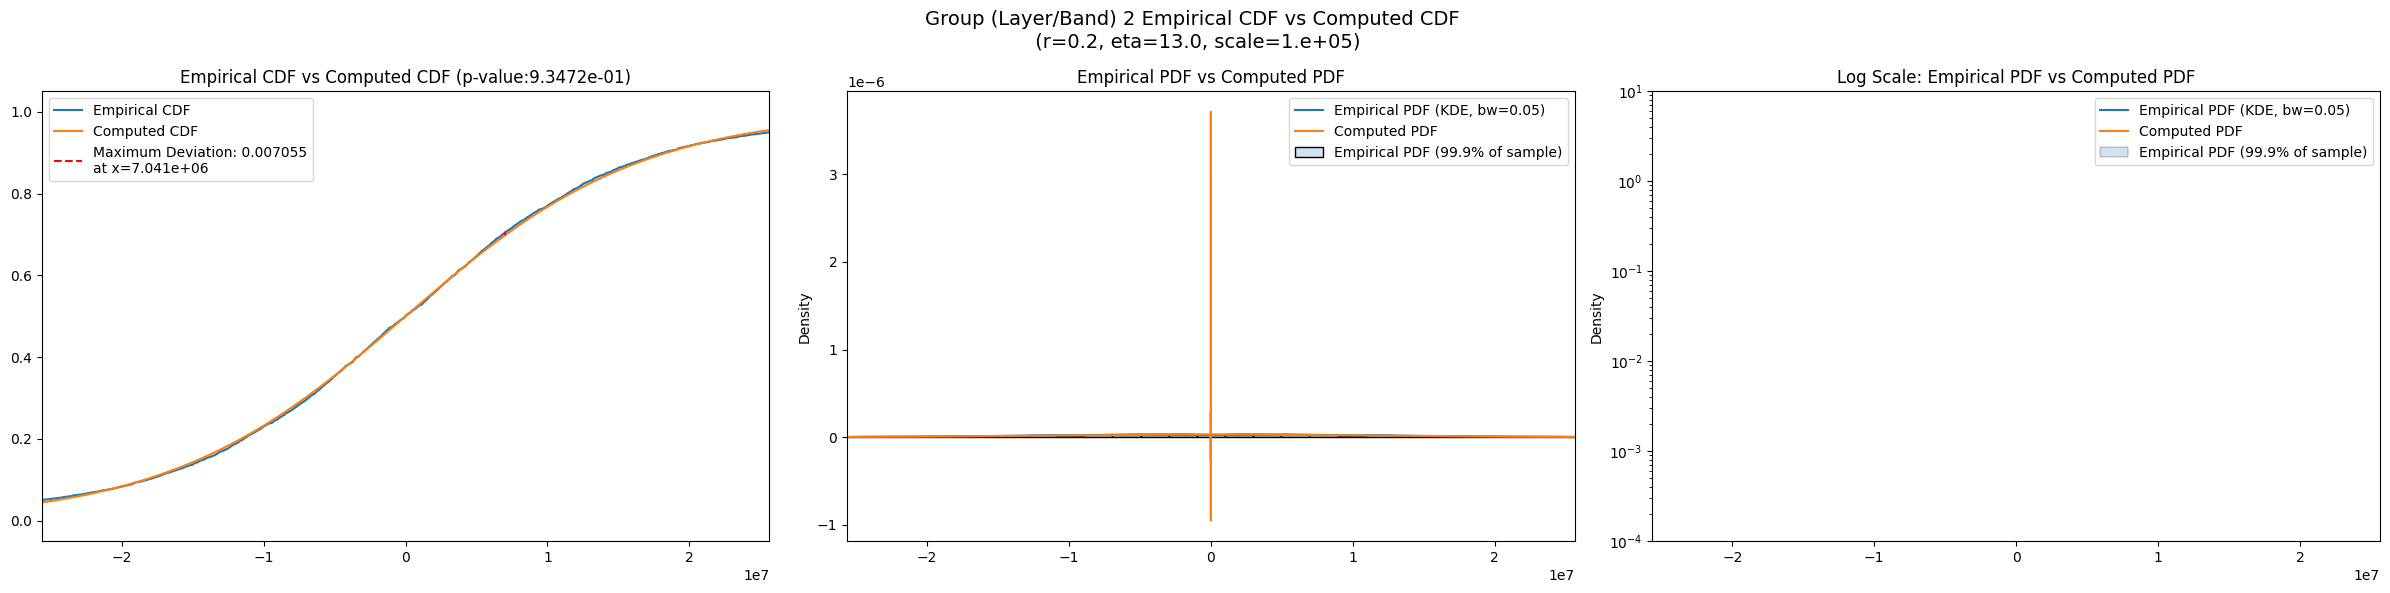

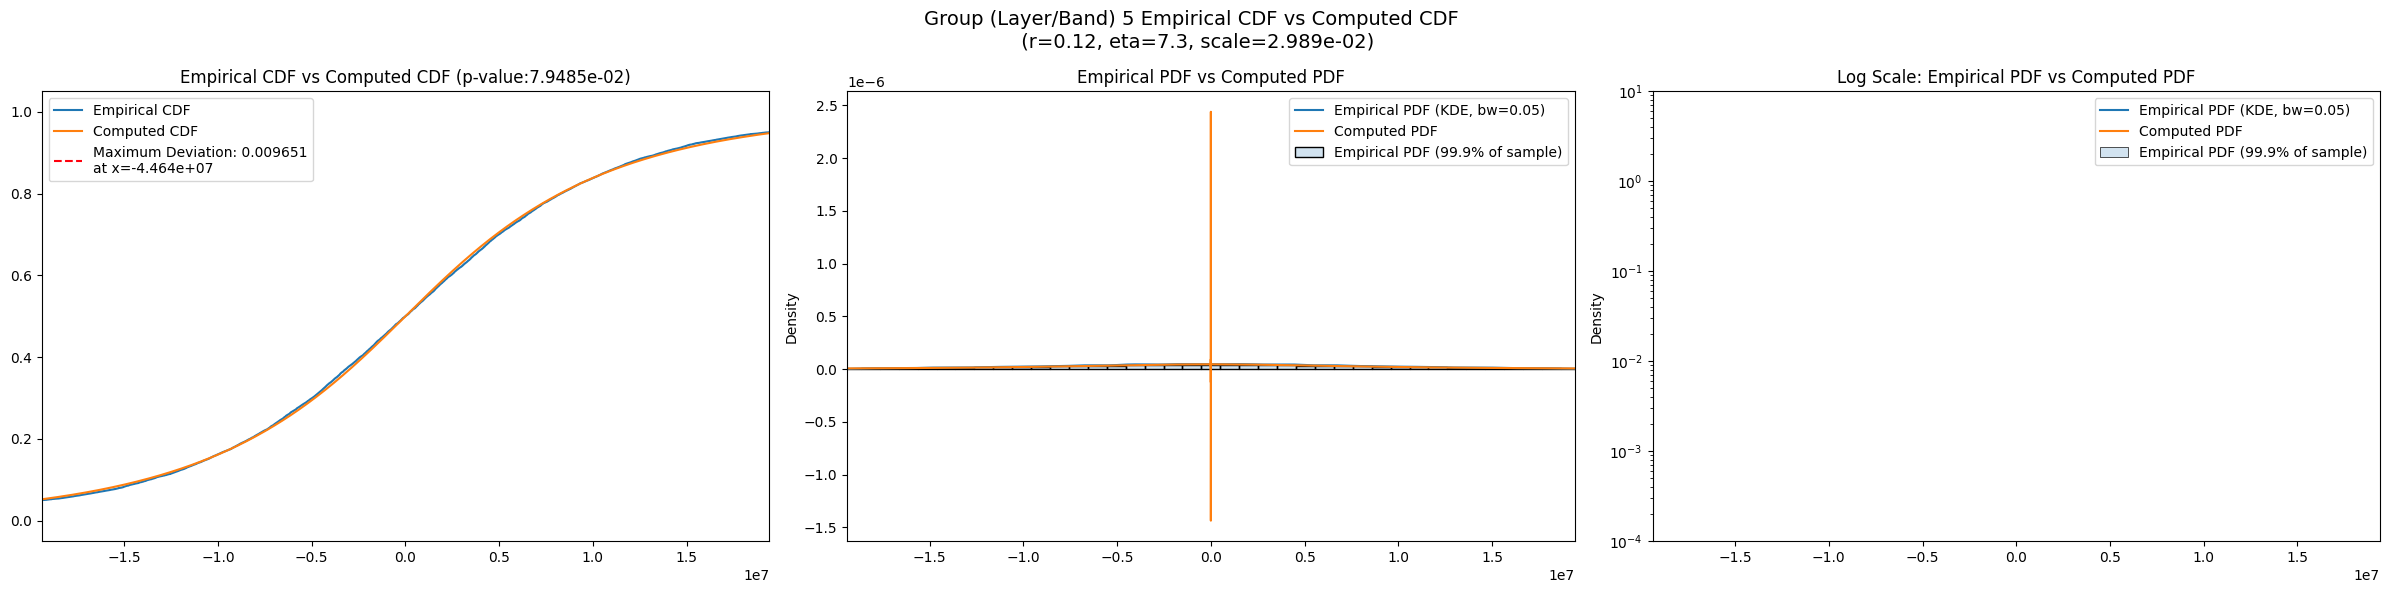

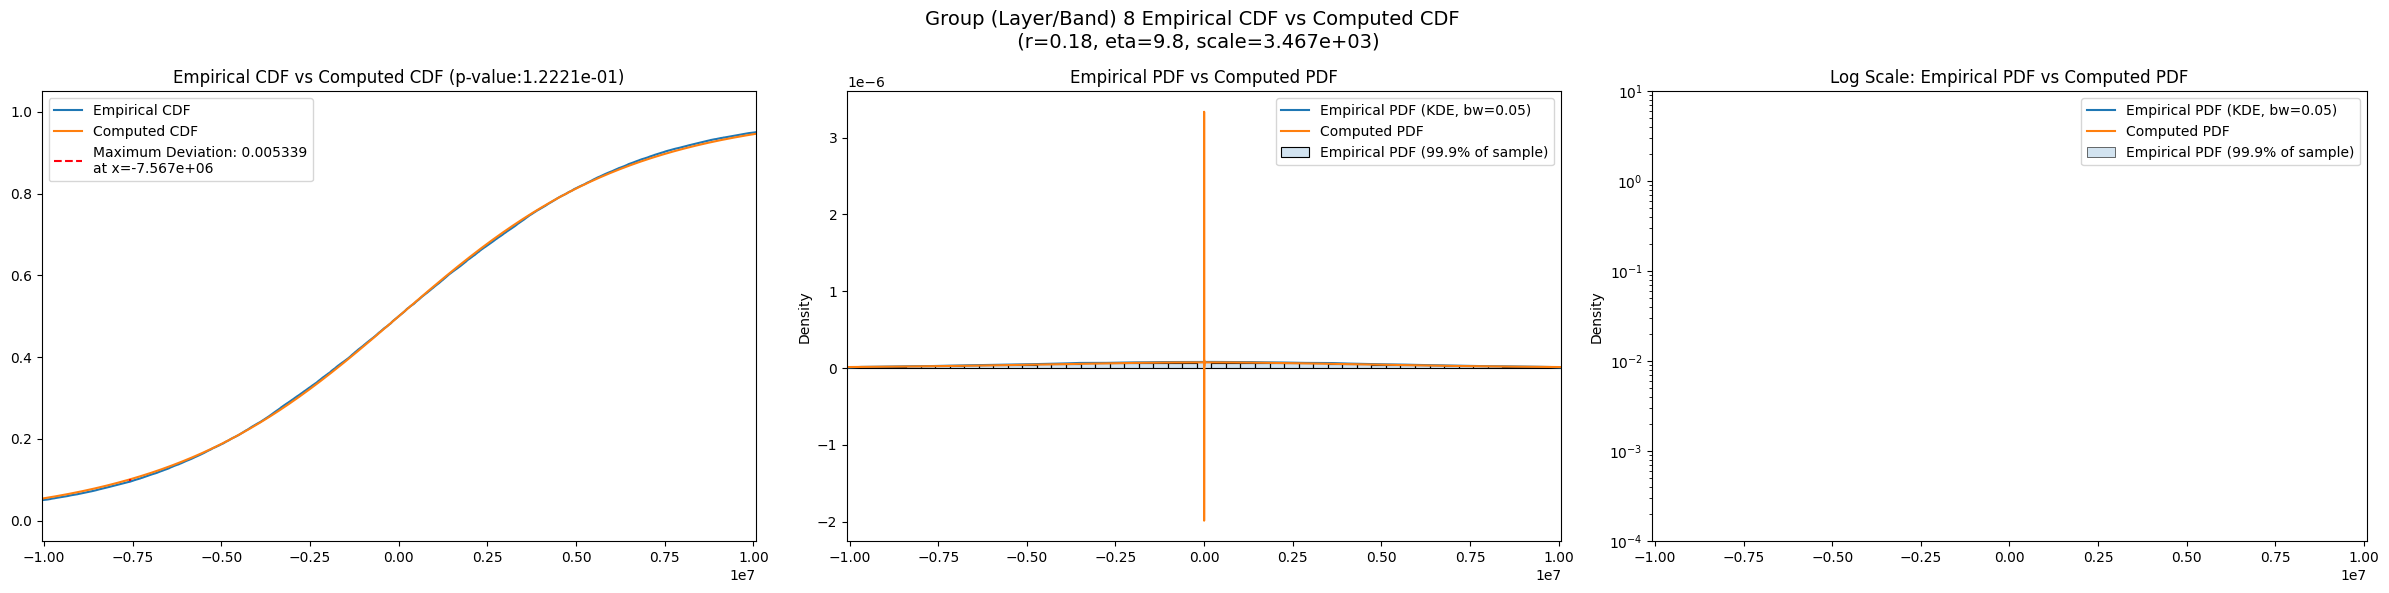

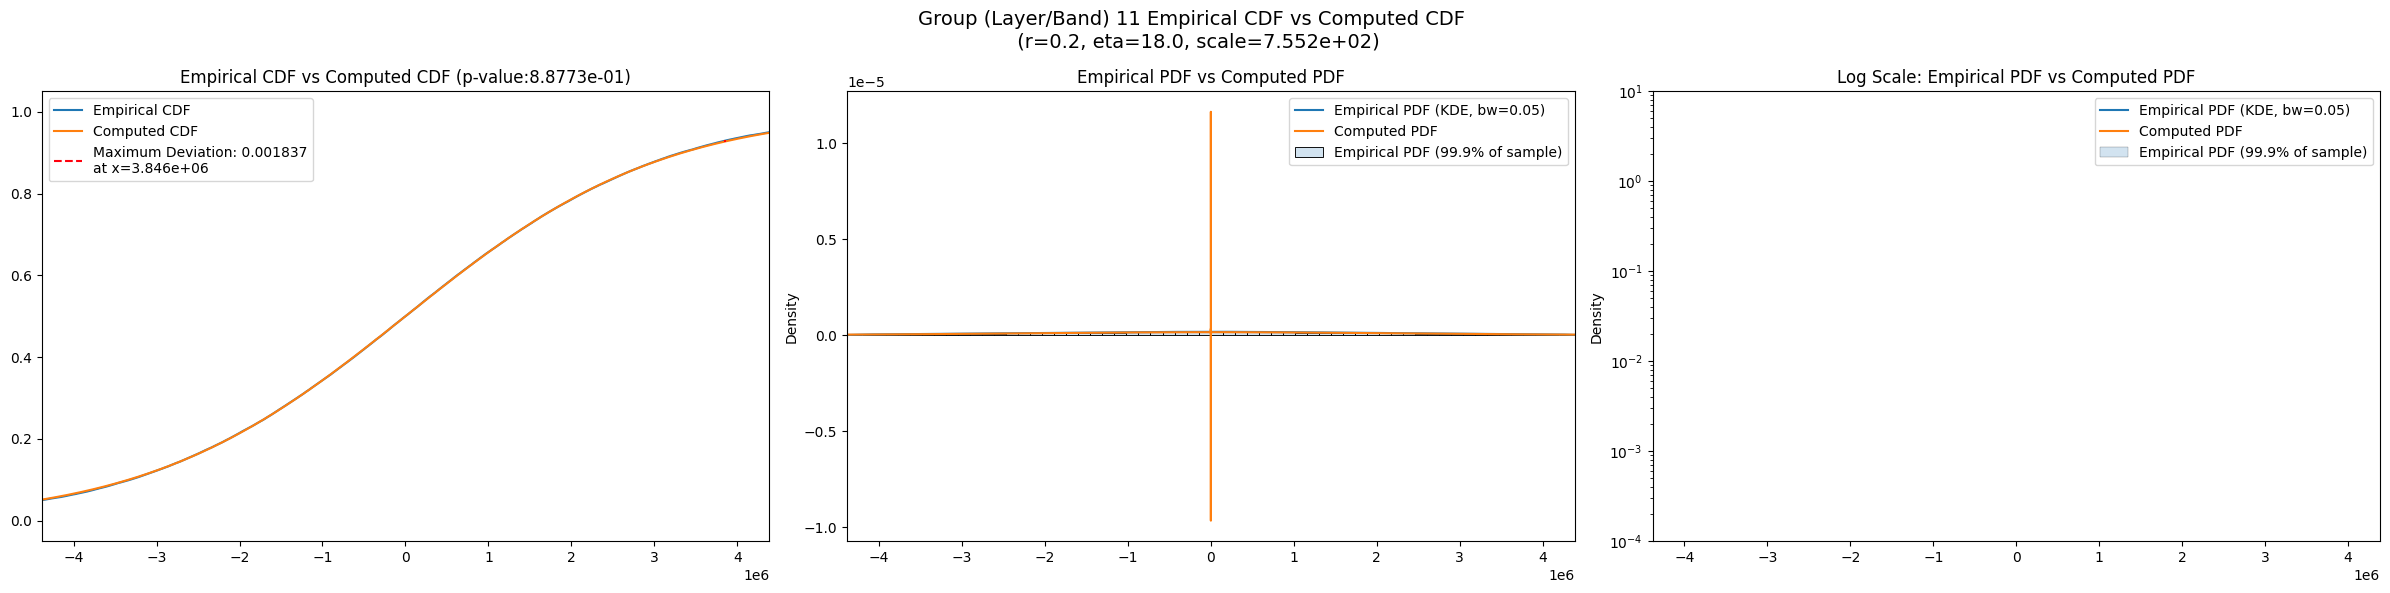

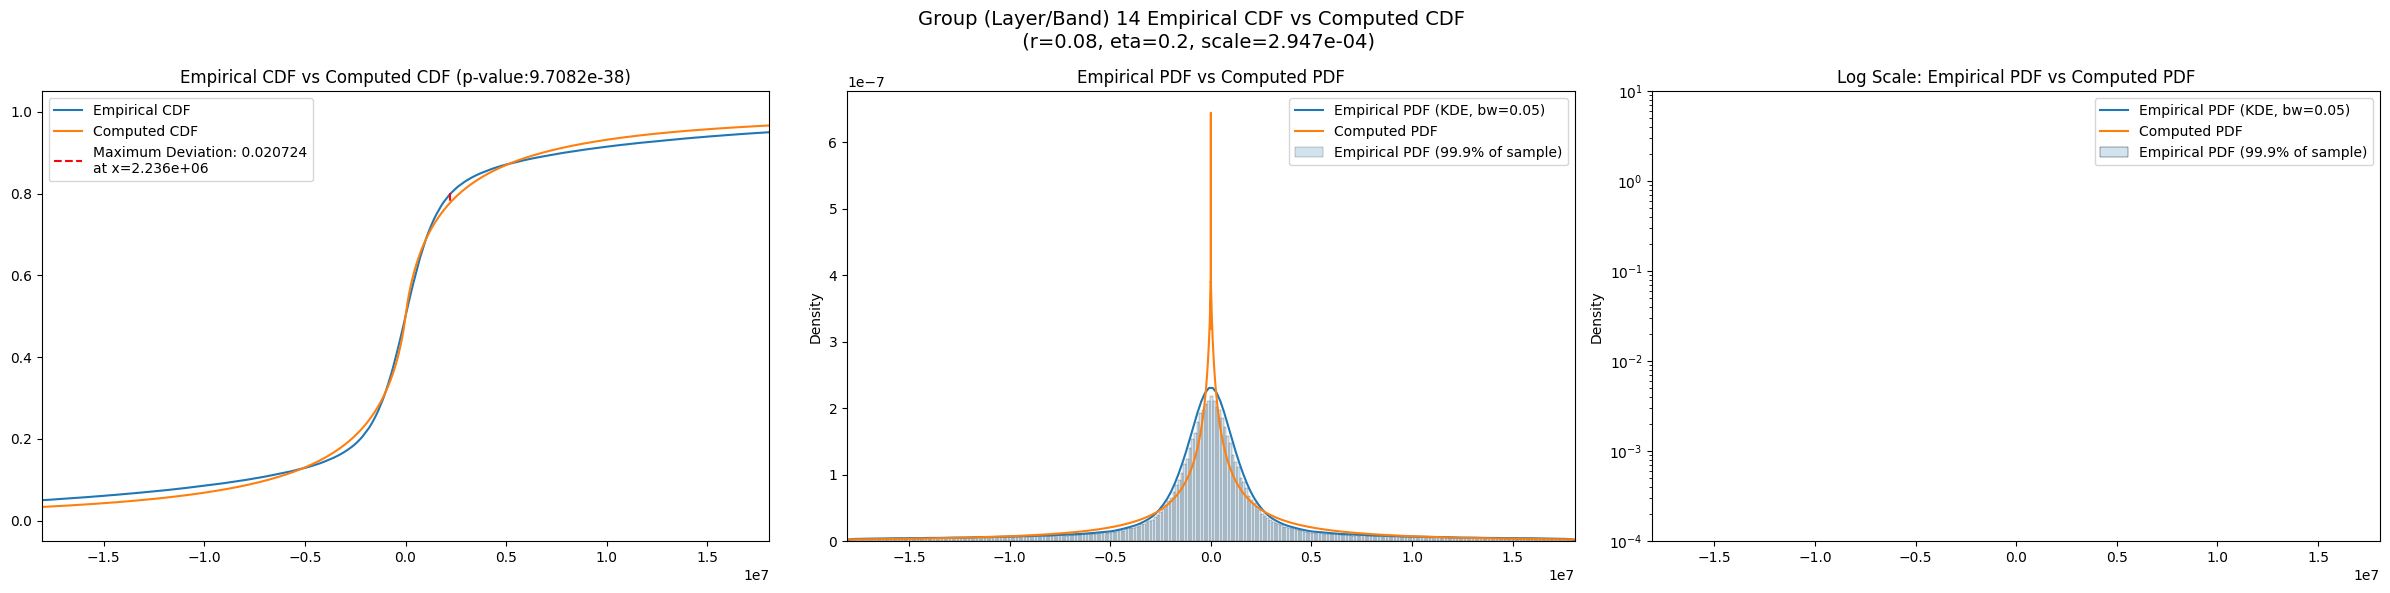

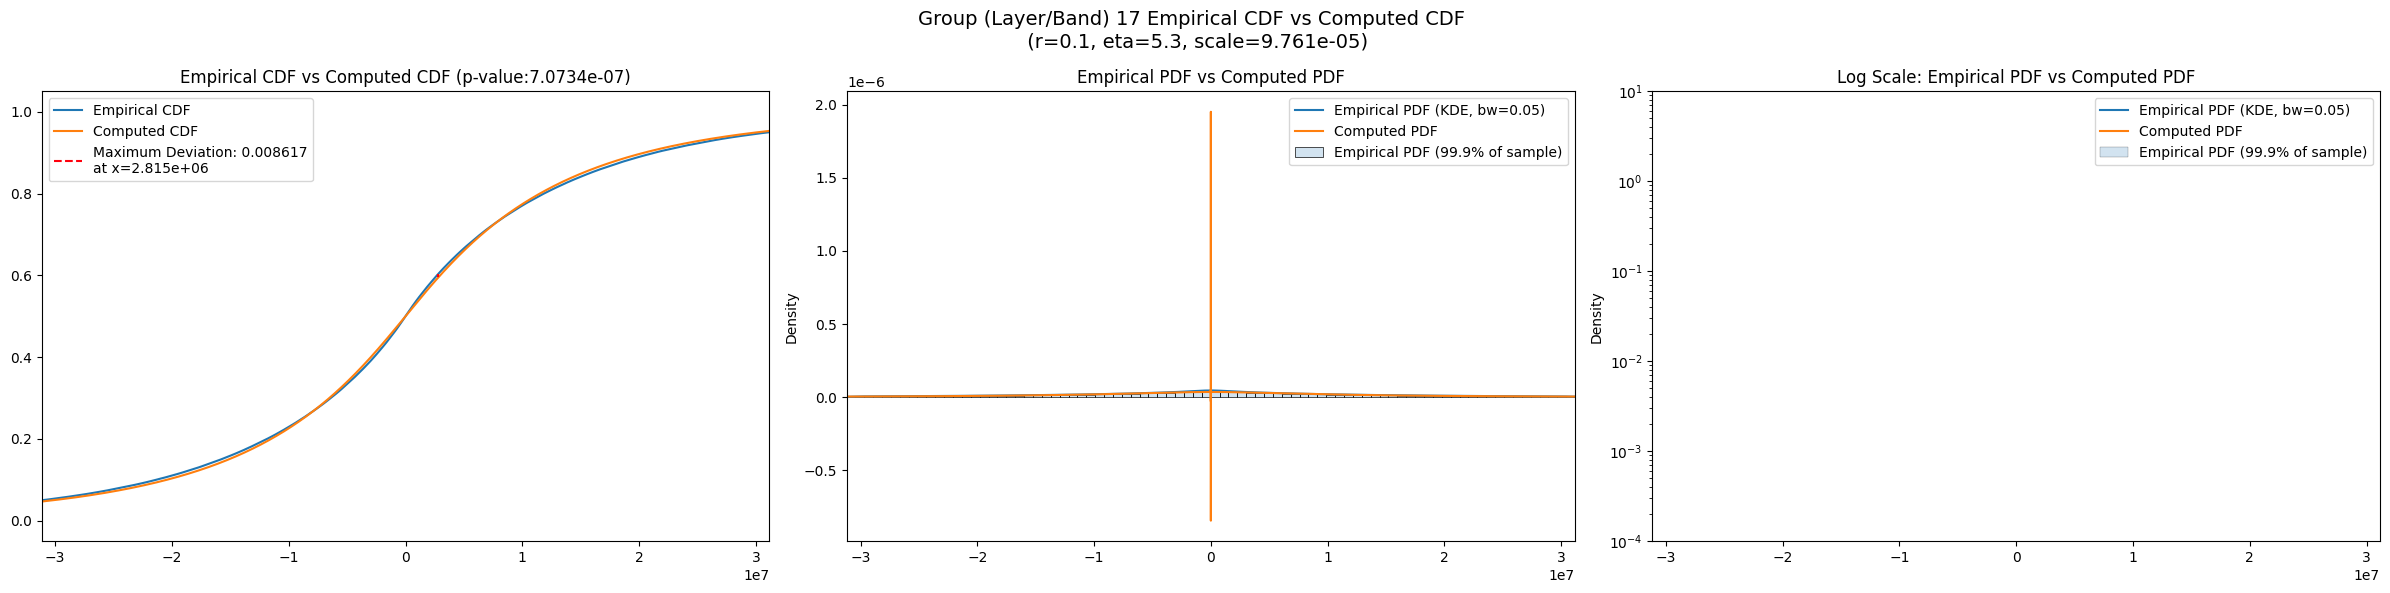

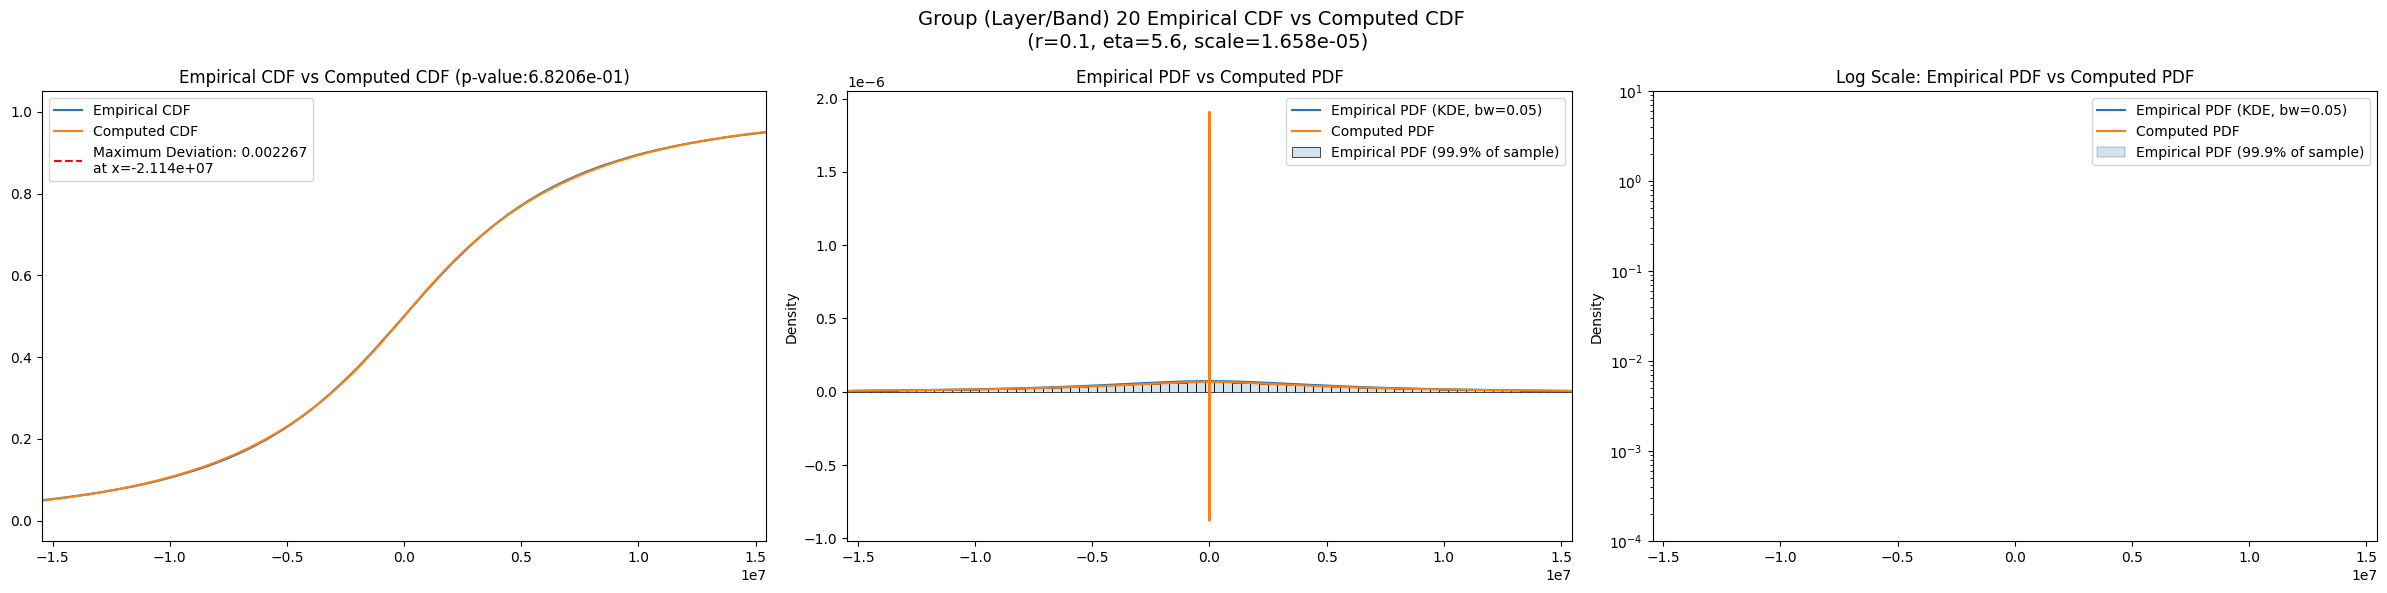

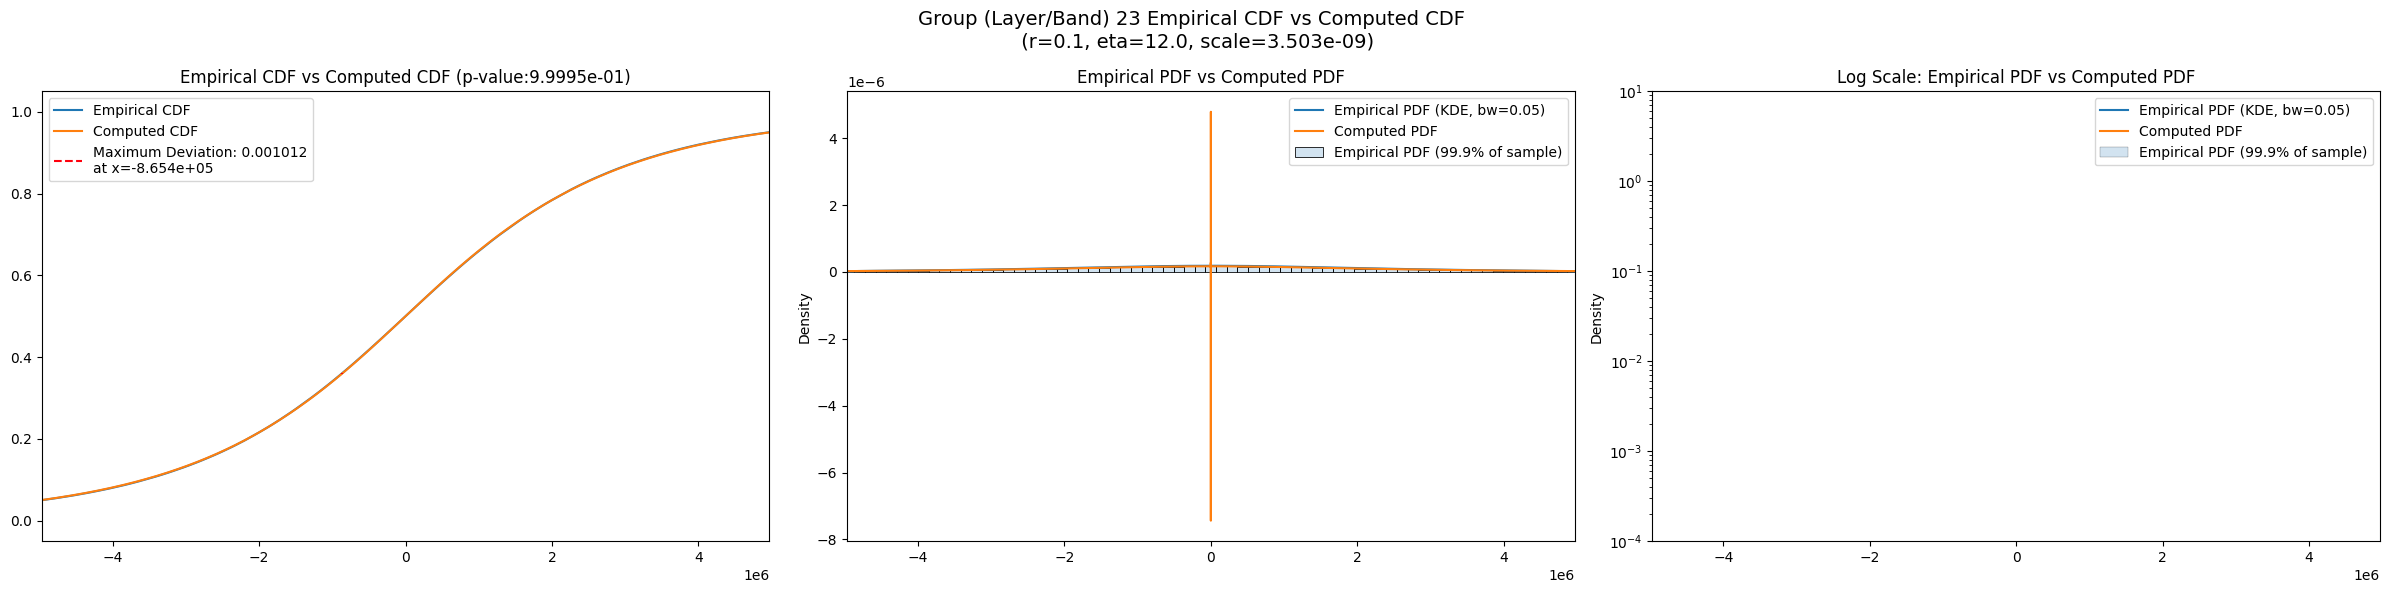

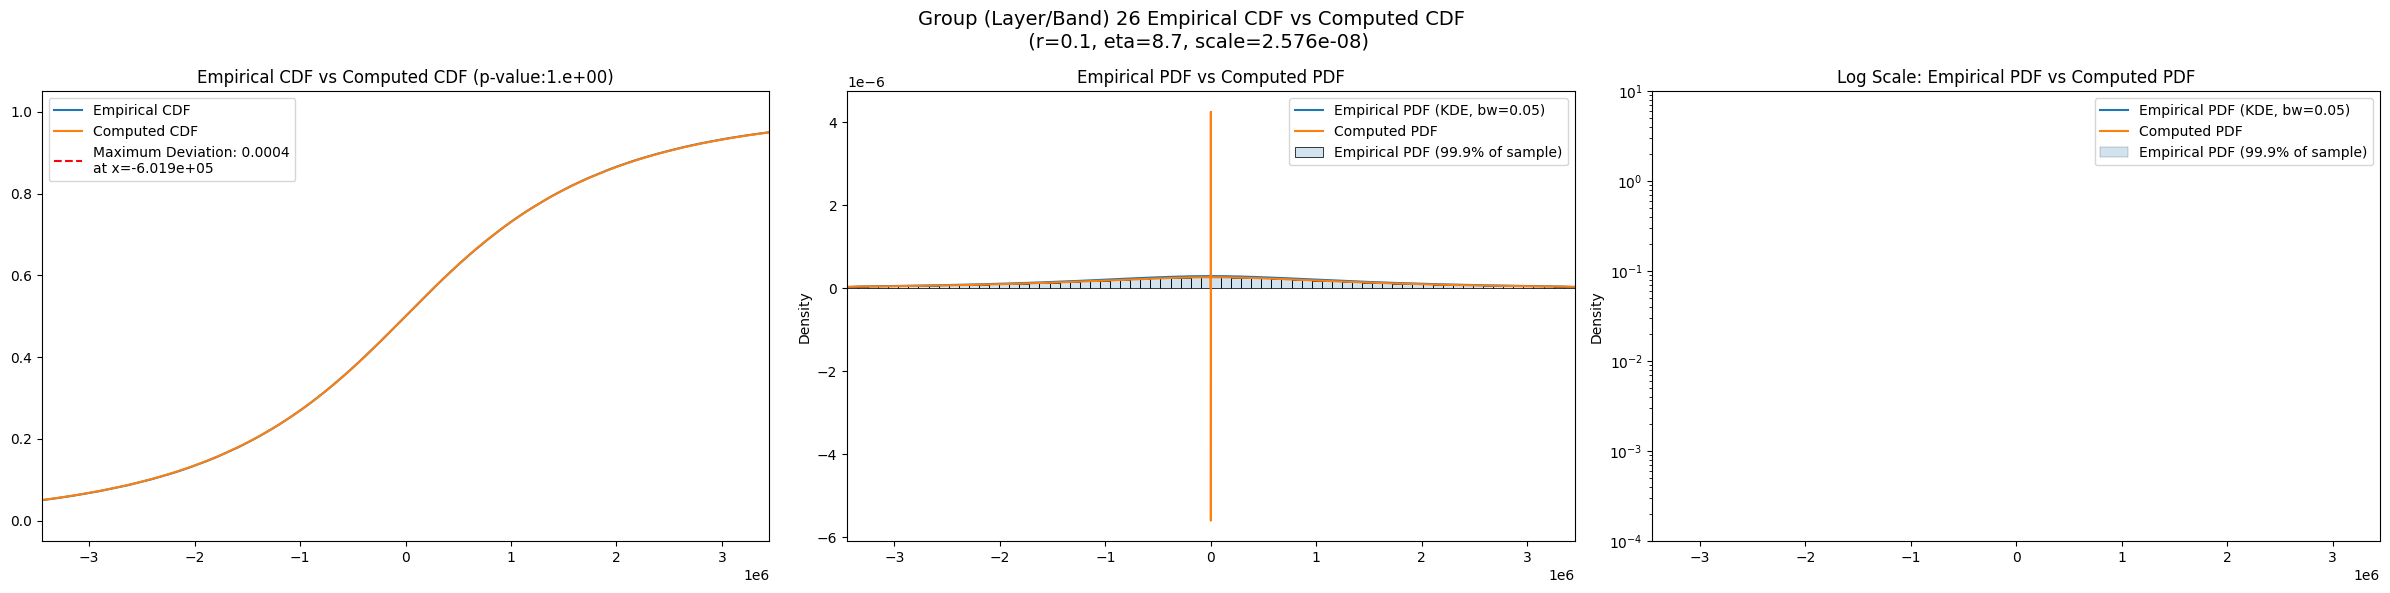

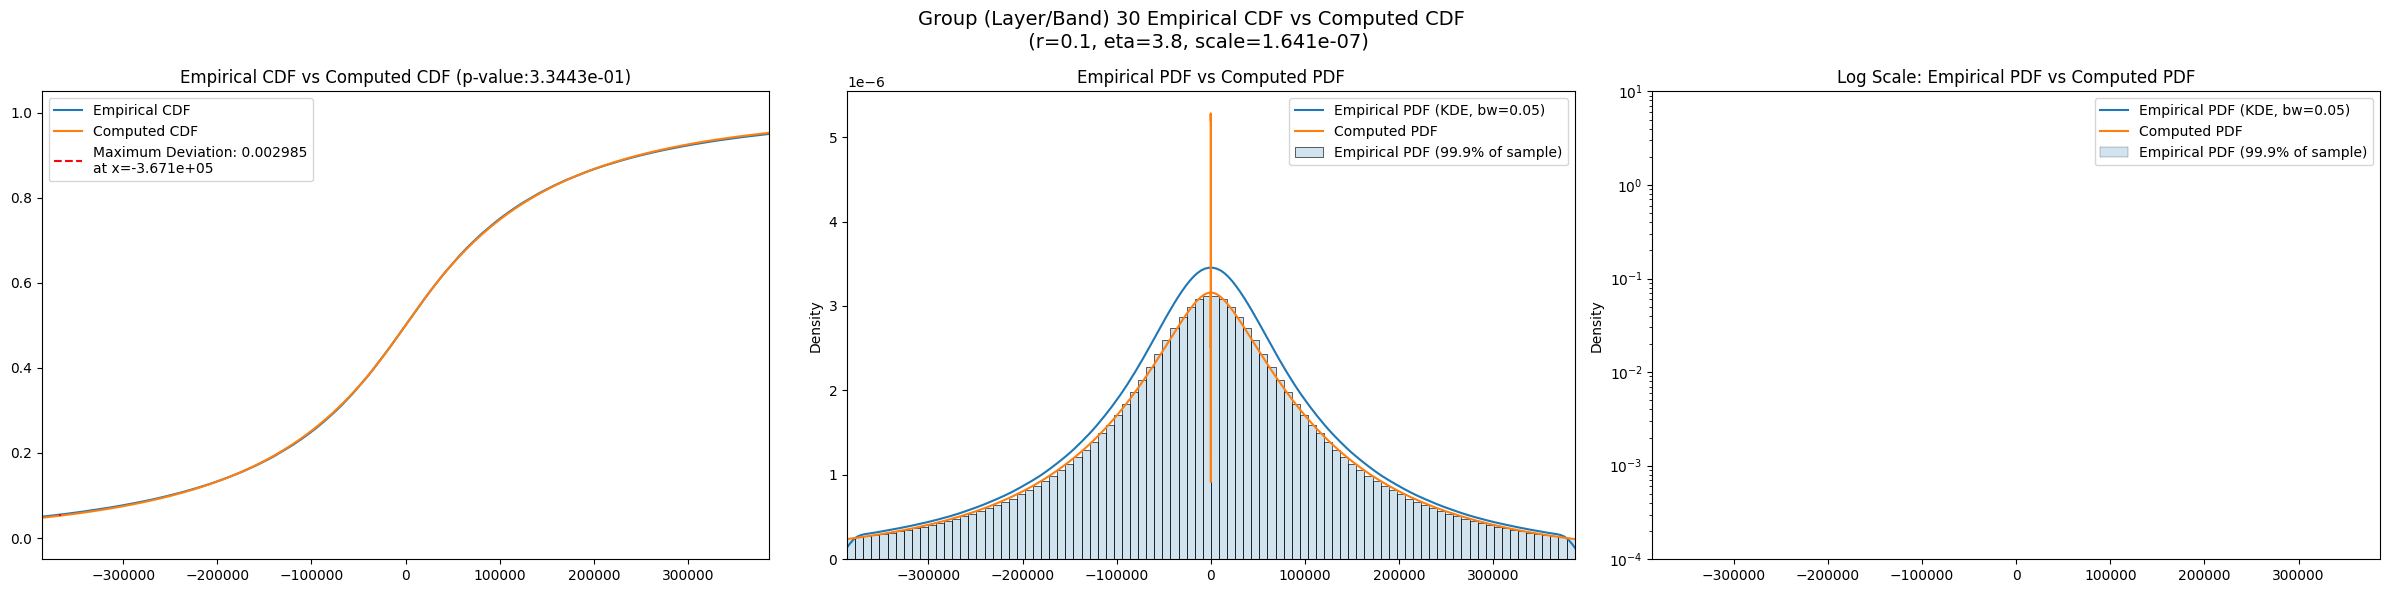

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     2.904819e+14  2.597059e+14  3.255609e+14   9.355459    5.162750   
5     4.573241e+14  3.783457e+14  5.454931e+14  48.455196   40.605025   
8     8.089669e+13  6.550185e+13  9.956697e+13  64.661690   38.623471   
11    8.118773e+12  7.500390e+12  9.011517e+12  10.821602    1.944767   
14    2.053679e+14  1.784178e+14  2.367104e+14  27.908864   17.313950   
17    3.885732e+14  3.623203e+14  4.174166e+14   5.466050    3.609352   
20    1.055018e+14  9.697142e+13  1.155315e+14   9.238367    5.192425   
23    1.032575e+13  9.608832e+12  1.124155e+13   7.135820    2.948350   
26    4.818805e+12  4.519782e+12  5.148273e+12   4.349167    2.838751   
30    6.401584e+10  5.894608e+10  6.974965e+10   8.475054    5.367546   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      13.226103         2880.0             0.007055        0.2         13.0   
5      56.285572         8640.0             0.010579        0.1          7.3   
8      90.369748        24480.0             0.005626        0.2          9.7   
11     31.858465        67680.0             0.001837        0.2         18.0   
14     49.301247       100000.0             0.021064        0.1         -0.1   
17      9.266543       100000.0             0.008617        0.1          5.3   
20     23.424463       100000.0             0.002268        0.1          5.6   
23     23.809514       100000.0             0.001012        0.1         12.0   
26      8.808062       100000.0             0.000400        0.1          8.7   
30     19.053446       100000.0             0.002985        0.1          3.8   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...       1000000.0              0.423590          0.000000e+00   
5     ...       1000000.0              0.394552          0.000000e+00   
8     ...       1000000.0              0.337562          0.000000e+00   
11    ...       1000000.0              0.208068          0.000000e+00   
14    ...       1000000.0              0.192484          0.000000e+00   
17    ...       1000000.0              0.402713          0.000000e+00   
20    ...       1000000.0              0.351062          0.000000e+00   
23    ...       1000000.0              0.206546          0.000000e+00   
26    ...       1000000.0              0.124235          0.000000e+00   
30    ...        175291.0              0.037367         9.383700e-122   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
band                                                                       
2         1000000.0             0.388085         0.000000e+00  1000000.0   
5         1000000.0             0.356224         0.000000e+00  1000000.0   
8         1000000.0             0.291694         0.000000e+00  1000000.0   
11        1000000.0             0.165048         0.000000e+00  1000000.0   
14        1000000.0             0.147308         0.000000e+00  1000000.0   
17        1000000.0             0.366462         0.000000e+00  1000000.0   
20        1000000.0             0.306866         0.000000e+00  1000000.0   
23        1000000.0             0.162892         0.000000e+00  1000000.0   
26        1000000.0             0.085633         0.000000e+00  1000000.0   
30         153598.0             0.010771         1.661880e-10   124926.0   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.365004   0.000000e+00          9.986229e-01  
5          0.332473   0.000000e+00          3.943033e-01  
8          0.267632   0.000000e+00          4.861537e-01  
11         0.139917   0.000000e+00          9.759929e-01  
14         0.123353   0.00000

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.007055                 0.025248          0.007055   
5                0.010579                 0.014591          0.009651   
8                0.005626                 0.008673          0.005339   
11               0.001837                 0.005218          0.001837   
14               0.021064                 0.004293          0.020724   
17               0.008617                 0.004293          0.008617   
20               0.002268                 0.004293          0.002268   
23               0.001012                 0.004293          0.001012   
26               0.000400                 0.004293          0.000400   
30               0.002985                 0.004293          0.002985   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.423590             0.388085       0.365004  
5                 0.394552             0.356224       0.332473  
8                 0.337562             0.291694       0.267632  
11                0.208068             0.165048       0.139917  
14                0.192484             0.147308       0.123353  
17                0.402713             0.366462       0.343109  
20                0.351062             0.306866       0.282857  
23                0.206546             0.162892       0.137756  
26                0.124235             0.085633       0.058809  
30                0.037367             0.010771       0.009149

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2           2.904819e+14          0.007055    0.20      13.0  1.000000e+05   
5           1.565211e+14          0.009651    0.12       7.3  2.989228e-02   
8           4.102203e+13          0.005339    0.18       9.8  3.466768e+03   
11          7.361758e+12          0.001837    0.20      18.0  7.552409e+02   
14          2.053679e+14          0.020724    0.08       0.2  2.947400e-04   
17          3.885732e+14          0.008617    0.10       5.3  9.761257e-05   
20          9.908266e+13          0.002268    0.10       5.6  1.658345e-05   
23          9.757013e+12          0.001012    0.10      12.0  3.503448e-09   
26          4.818805e+12          0.000400    0.10       8.7  2.576462e-08   
30          6.401584e+10          0.002985    0.10       3.8  1.640739e-07   

      best_exclude_cutoff  
band                       
2                     0.0  
5                   125.0  
8                   175.0  
11                  100.0  
14                    0.0  
17                    0.0  
20                   50.0  
23                   50.0  
26                    0.0  
30                    0.0